In [1]:
from collections import defaultdict
import re
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os.path
import time
from PreprocessStage2 import RemovingDuplicatesandCreateDataFame,weightedNodes
from graphProcessing_Recifading import fadingSimilarity,getNodeFromWeightedSimilarityMatrix,getTFIDF
from algorithms import getClusterSet
from wordcloud import WordCloud,STOPWORDS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
stopwords = set(STOPWORDS)

In [3]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

### **TODO**:
Need to create a vocabulary of all the words in all the clusters along with the count and tweet_id(set/list of tweetIds). After deleting the tweet_id if the count is 0(the tweetId column could be empty), then delete those words from the cluster(s). 




In [4]:
df = pd.read_csv("tenEvent_2000_per_withLabel_NonEnglish_Removed.csv")
df = df.drop([df.columns[0],df.columns[1],'sentance','paper_text_tokens','NumberOfRT','NumberOfForward','label'],axis=1)

In [5]:
df.head()

Id      Username  \
0  165514961626468352  DougRoxTV      
1  165513729323188224  Rubens1992     
2  165513815574847488  kym_johnson    
3  165515464951341056  GTechStorage   
4  165514792386314241  ARQ007         

                                                                                                                                          text  \
0  #Giants fans prefer Lipton Brisk Iced Tea, while a #Patrios fan prefers #Gatorade #ImnotmakinthisStuffup #SuperBowl #FunFacts                 
1  Este Domingo la 46 #SuperBowl con la final entre los New York Giants y los New England Patriots!!!!!!                                         
2  Two days until the #SuperBowl! What do you like better, the game or the cool commercials?                                                     
3  NAC is handing over 4 of its super slow-mo cameras to the #SuperBowl so we can see the action at 1,000 fps. Learn more: http://ow.ly/8RxoW    
4  @AmandaJDavies Fab top, grrrrr!:-) All at gym liked it. My 10 yo daughter loves it! Great to see something on #SuperBowl too.                 

    Timestamp  
0  1328248200  
1  1328247900  
2  1328247900  
3  1328248320  
4  1328248140

In [6]:
df["NounList"] = RemovingDuplicatesandCreateDataFame(df.text.values) ## commented preprocess function in getNounList
df.drop_duplicates(subset=['Timestamp','Username'],keep = 'first',inplace = True)
df['NounList'] = df.NounList.map(lambda x: [t for t in x if len(t) > 2])
df['NounWords'] = df.NounList.apply(lambda row: ' '.join(row))
df['NounWords'] = df['NounWords'].apply(lambda x: 'NaN' if type(x)==float else x )
df = df[df['NounWords'] != 'NaN']
df = df.sort_values(by=['Timestamp'],ascending=True)

In [7]:
train_df = df.head(1500)
test_df = df.tail(len(df)- 1500)

In [8]:
test_df.reset_index(inplace=True)
test_df = test_df.drop(['index'], axis=1)
train_df.reset_index(inplace=True)
train_df = train_df.drop(['index'], axis=1)

In [9]:
train_df

Id         Username  \
0     483858381434675200  ConnieKennedy     
1     165518502323683328  tree_bro          
2     483858540994383872  docspidey         
3     483858722054094848  piyaztamatar      
4     165519965020094464  chevrolet         
...                  ...        ...         
1495  165524506889302016  SipWatchTweet     
1496  165524666759385088  BrittneyNespola   
1497  165524614989090817  Gary_Stewart1     
1498  165524558772846592  hcshenanigans     
1499  165524471577452546  StephenReitter    

                                                                                                                                                     text  \
0     If #swineflu didn't kill 70 in #Ukraine, was it Ebola? Pneumonic plague? Was a bioweapon unleashed? Lord have mercy. http://bit.ly/4zjfFQ             
1     Why Can't I Find Out Anything About This Superb Owl #superbowl                                                                                        
2     pocket full of sunshine waiting for the doctor to come back in, hope i'm not a walking bioweapon from all the ebola i was playing in earlier          
3     what could be the major bioweapon in #WW3. 1-Ebola 2-Mutated HN series, 3-HIV, 4- any orthomyxo family 4- Influenza A. my guess ?????????             
4     Your trivia skills may win you a new #Chevy during #SuperBowl XLVI. Find out how through the #ChevyGameTime app: http://spr.ly/6015RvJD               
...                                                                                                                                        ...              
1495  New York Giants| Roster http://www.giants.com/team/roster.html … via @Giants #Superbowl #WinePairing--> *New York State Bully Hill Wines' Riesling*   
1496  great idea!! “ @JenniferHeimann: Navy blue nails in honor of GMEN!! #superbowl”                                                                       
1497  Homemade beer is done fermenting after 2 weeks! Conditioning a few days then drinking some homemade BOBO Juice! #SuperBowl                            
1498  Its fridayyy so #pumped for a great weekend.. Still wondering on who to cheer on at the #superbowl...                                                 
1499  Just ate a bomb omelet..Mmm 2 more days #supersunday #superbowl                                                                                       

       Timestamp  \
0     1257204780   
1     1296972240   
2     1319595780   
3     1326746580   
4     1327197600   
...          ...   
1495  1328250480   
1496  1328250480   
1497  1328250480   
1498  1328250480   
1499  1328250480   

                                                                                   NounList  \
0     [swineflu, kill, ukraine, ebola, pneumonic, plague, bioweapon, lord, mercy]             
1     [anything, superb, owl, superbowl]                                                      
2     [pocket, sunshine, doctor, hope, bioweapon, ebola]                                      
3     [bioweapon, ebola, series, hiv, orthomyxo, family, influenza, guess]                    
4     [trivia, skill, win, chevy, superbowl, xlvi, chevygametime, app]                        
...                                                                ...                        
1495  [york, giant, roster, giant, superbowl, york, state, hill, wine]                        
1496  [idea, jenniferheimann, navi, blue, nail, honor, gmen, superbowl]                       
1497  [homemade, beer, week, conditioning, day, drinking, homemade, bobo, juice, superbowl]   
1498  [fridayyy, pumped, weekend, cheer, superbowl]                                           
1499  [ate, bomb, omelet, mmm, day, supersunday, superbowl]                                   

                                                                       NounWords  
0     swineflu kill ukraine ebola pneumonic plague bioweapon lord mercy           
1     anything superb owl superbowl             

In [10]:
test_df.head(50)

Id         Username  \
0   165524631376236546  CustomMade        
1   165524588913102848  kellydomara       
2   165524460617728001  TVWORTHWATCHING   
3   165524631875371009  pyz1k             
4   165524583229820928  cafesatmoma       
5   165524508252446720  crystal_maleski   
6   165524535603494912  KauferDMC         
7   165524633259491328  girlbureaucrat    
8   165524465780928512  Coachforyou       
9   165524595057766400  ZoomTilt          
10  165524523259670529  Indy2018Bid       
11  165524669515051009  AllieC8           
12  165524517823852544  IBTimesEnt        
13  165524903645290496  kimtrandc         
14  165524882006876160  TonyaHallRadio    
15  165524815615238144  ClipperDirect     
16  165524720832356355  Deleted83090467   
17  165524952659918849  DJ_6_6            
18  165524797822996480  TheYardsDC        
19  165524901044830208  OhSnapImThatGuy   
20  165524825975177216  RichardMerrill    
21  165524726951837697  kvendeland        
22  165524916563750912  BillP             
23  165524826084220931  1310NEWS          
24  165524776268468224  StephenSchatz     
25  165524826553978881  bigwalsh12        
26  165524712896733184  PurdysChocolate   
27  165524799374897152  toe_knee_touch    
28  165524845281558528  GrillingwRich     
29  165524873475657728  sherryaliberti    
30  165524722904350720  mybariatricteam   
31  165524876306825216  Pohibear          
32  165524933085110273  JerrilynnA        
33  165524914894409728  anniesgoathill    
34  165524792643043328  isponsor          
35  165524945160507392  matarilestore     
36  165524943445037056  schwartzdavidb    
37  165524712888340480  sonnylebythebay   
38  165524780752179200  _J_Hova_IS        
39  165524720228384768  hal2814           
40  165524908959473664  TadaTheater       
41  165524785323978754  jmills25          
42  165524829712285696  ErikGriffin       
43  165524913669672960  bananagrams       
44  165524851912740864  jasonwheelertv    
45  165524717661458434  thekguru          
46  165524742378491904  MundiG            
47  165524911643836418  localclowncrew    
48  165524867326803970  Zatarains         
49  165524911287316480  Sports_Biz_Prof   

                                                                                                                                                                                                                               text  \
0   CustomMade Pick of the Day— Steel Football Sculpture. Spin it for luck! http://www.custommade.com/steel-sculpture-football-team/by/prairieartmetal … #SuperBowl                                                                   
1   50 Things to Watch Besides the #SuperBowl: http://blogs.sfweekly.com/exhibitionist/2012/02/50_shows_to_watch_instead_of_t.php …                                                                                                   
2   #SuperBowl Musical Mania: #Madonna at halftime, #TheVoice afterward & #Smash the next day http://bit.ly/wJ3L8k                                                                                                                    
3   gotta love leavin work early on #SuperBowl weekend                                                                                                                                                                                
4   RT @museummodernart: Five for Friday: The Fine Art of [American] Football - http://bit.ly/zOLtjw  #SuperBowl                                                                                                                      
5   TY!!RT @sylvlima: I'm not a big cooking gal & LOVE easy & great tasting recipes.But,try this #chili for #SuperBowl! http://bit.ly/9HQgmV                                                                                          
6   8 Companies That Wasted The Most Money On Super Bowl Advertising http://j.mp/xwJQEh  #superbowl #sportsmarketing                                                                                             

In [11]:
train_df.shape, test_df.shape

((1500, 6), (11152, 6))

In [12]:
timestamp = train_df.Timestamp.values
NounList = train_df.NounList.values

In [13]:
TFIDF = getTFIDF(train_df.NounList.values)

In [14]:
%time
similarity_matrix = fadingSimilarity(train_df.NounList.values,timestamp,train_df.shape[0])
tweetId = train_df.Id.values
weightedSimilarityMatrix = weightedNodes(similarity_matrix,tweetId)
adjacency_list = getNodeFromWeightedSimilarityMatrix(weightedSimilarityMatrix,tweetId)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


In [15]:
weightedSimilarityMatrix=None
similarity_matrix=None

In [16]:
%time
cluster_set={}
cloud=[]
density_param = [0.0000003]
#counting_batch, numberCoreEdges, numberCorePosts, numberClusters, cluster_set, cloud, numberEdges,id_list = 
cluster, cloud = getClusterSet(test_df,TFIDF,train_df,adjacency_list,cluster_set,density_param)


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.4 µs
total batches:: 7
----------------------------------------------------------------------------------------------------------
Batch:  1
First, performing linkage search on train data
Now, performing linkage search on test data
Updating the test ls indices with the train to get one dictionary altogether
Linkage search takes:  209.86817932128906
Tweet is  0    CustomMade Pick of the Day— Steel Football Sculpture. Spin it for luck! http://www.custommade.com/steel-sculpture-football-team/by/prairieartmetal … #SuperBowl
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1    50 Things to Watch Besides the #SuperBowl: http://blogs.sfweekly.com/exhibitionist/2012/02/50_shows_to_watch_instead_of_t.php …
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts ar

_______________________________________________________________________
Tweet is  13    In my world, Animal Planet's #PuppyBowl > #SuperBowl but I AM excited for our friend's SuperBowl party this Sun! Yes to good food & company!
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll rock it at #magiclv or #KeepIt100 for ya. ;)
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: objec

Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll rock it at #magiclv or #KeepIt100 for ya. ;)
Name: text, dtype: object
91    The NFC has won 14 straight #SuperBowl coin flips (odds of that happening are .006 percent): http://es.pn/ziQEkN 
Name: text, dtype: object
88    Is everyone as excited as I am that 87 year old #Madonna is playing at the halftime #SuperBowl ? #skeletorarms
Name: text, dtype: object
89    #MetLife announced pretty huge news– they have a #Superbowl commercial this year! Hint: It has 2 do w/ lots of well

_______________________________________________________________________
Tweet is  34    Breaking News :) NY Giants special-teams captain reveals coin-toss choice: tails #SuperBowl
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  35    JUEGO DE BAR SLINGSHOT #SuperBowlpic.twitter.com/AEBpcxPu
Name: text, dtype: object
This post has : 13  core posts.
This post has : 7  border posts.
Core posts are::
542    omg.. The #SuperBowl Coming Soon ..'
Name: text, dtype: object
541    ITs good to hear that #5FormerSuperBowlBroncos will be attending the #SuperBowl
Name: text, dtype: object
840    Who's ready for the #Superbowl? Which team will you be cheering for? The @gtrot team is split!
Name: text, dtype: object
601    Top 5 #SuperBowl Commercials of 2012 http://technorati.com/sports/football/article/top-5-superbowl-commercials-of-2012/ …
Name: text, dtype: object
594

This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
73    We're proud of you @Kennedy73! Bring it home for all New York! http://on.fb.me/zZxZFJ  #Giants #Yonkers #SuperBowl
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll rock it at #magiclv or #KeepIt100 for ya. ;)
Name: text, dtype: object
91    The NFC has won 14 straight #SuperBowl coin flips 

_______________________________________________________________________
Tweet is  59    Lateral pass from Boomer to Shannon Sharpe then to Barry Sanders for a Titans TD. #SuperBowl
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
1266    #Feds Seize 307 Sports Domains Ahead of Sunday’s #SuperBowl....if this happens without #SOPA. What the hell happens if that did pass?!?
Name: text, dtype: object
1269    Idc who wins this particular #superbowl I'm just looking forward to the party.
Name: text, dtype: object
1276    #SuperBowl 2012: Where to watch in #DC, what to make http://wapo.st/zwz09z 
Name: text, dtype: object
1297    Some of the best #superbowl commercials in recent years. @lifecrowder. http://www.lifecrowd.com/blog/sports/retro-super-bowl-commercial-recap#comment-3516 …
Name: text, dtype: object
1287    Happy Friday, have a great #SuperBowl Weekend! http://fb.me/1db18j0xe 
Name: text, dtype: object
1277    We watched @nf

_______________________________________________________________________
Tweet is  70    Was there ever a time that storytelling didn't score big? #marketing #SuperBowl #advertising http://ow.ly/8RqZc 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
85    @100

_______________________________________________________________________
Tweet is  81    VIDEO RECAP: Interviews, anecdotes, etc. from the #Patriots and #Giants heading into #Superbowl Sunday. http://www.pepperonsports.com 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
71    New York - Watch El #Superbowl at @SalonHecho Sunday, February 5th! cc: @HechoEnDumbo http://ht.ly/8Rg5f 
Name: text, dtype: object
73    We're proud of you @Kennedy73! Bring it home for all New York! http://on.fb.me/zZxZFJ  #Giants #Yonkers #SuperBowl
Name: text, dtype: object
70    Robert Kraft talked the business of the #SuperBowl on @SquawkCNBC this morning. Video: http://bit.ly/Aqdrob 
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll rock it at #magiclv or #KeepIt100 for ya. ;)
Name: text, dtype: object
69    VIDEO: Mayor @MikeBloomberg & @MayorTomMenino in new #SuperBowl ad to #TackleIllegalGuns. Watch at: ht

_______________________________________________________________________
Tweet is  92    Who is excited about the #superbowl? being in NYC we definitely are! Any one out there lucky enough to be going? cc: @Giants
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
73    We're proud of you @Kennedy73! Bring it home for all New York! http://on.fb.me/zZxZFJ  #Giants #Yonkers #SuperBowl
Name: text, 

_______________________________________________________________________
Tweet is  102    Betting on the #SuperBowl might seem harmless, but for some, gambling can become an addiction & take over finances: http://ow.ly/8RcaI 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, 

_______________________________________________________________________
Tweet is  116    Now I am a huge football fan, but for others - some help: 5 Ways to Seem Smart About the Super Bowl http://www.time.com/time/nation/article/0,8599,2106068,00.html … #superbowl
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
56    Why The NFL And The Super Bowl Are A Lot Like Socialism, By Bill Maher #BillMaher #NFL #SuperBowl #Hilarious http://j.mp/zX8rKp 
Name: text, dtype: object
93    Officially rena

_______________________________________________________________________
Tweet is  127    #SuperBowl 2012: Why Big Game Will Be Among History's Elite - http://me.lt/21NSv 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
72    It's #FuelUpFriday! Check out @NFL #Superbowl rivals as they come together 4 the game & 2 support dairy! #FUTP60pic.twitter.com/KpgSTlFg
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
75    #BigGames this weekend - Chelsea vs

_______________________________________________________________________
Tweet is  142    FREE shuttle runs 11 am to 2 am for Mass Ave, Fountain Square, Gov't Center, City Market. 5 shuttles running now! #superbowl #DiscoverIndy
Name: text, dtype: object
This post has : 1  core posts.
This post has : 19  border posts.
Core posts are::
358    Have a Great #SuperBowl Weekend!
Name: text, dtype: object
_______________________________________________________________________
Tweet is  143    Just in time for the #SuperBowl, Madonna's new football-tastic music video: http://bit.ly/zZwQ7c  #SB46 #Social46
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
93    Officially renamed Manning’s 

This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
72    It's #FuelUpFriday! Check out @NFL #Superbowl rivals as they come together 4 the game & 2 support dairy! #FUTP60pic.twitter.com/KpgSTlFg
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll rock

_______________________________________________________________________
Tweet is  165    @davidgerzof Magic Hat, Howl. Awesome #SuperBowl
Name: text, dtype: object
This post has : 8  core posts.
This post has : 12  border posts.
Core posts are::
358    Have a Great #SuperBowl Weekend!
Name: text, dtype: object
337    Who will you be cheering for during the #Superbowl this weekend?
Name: text, dtype: object
595    Let's hear your #SuperBowl picks: Giants or Patriots?
Name: text, dtype: object
438    Gearing up for #SuperBowl 2012 Ad-Off http://bit.ly/zSvucw  http://iMediaConnection.com 
Name: text, dtype: object
384    @Patriots to win #superbowl on sunday =D
Name: text, dtype: object
588    “ @CallMeMarley READY FOR SUNDAY #SUPERBOWL”
Name: text, dtype: object
601    Top 5 #SuperBowl Commercials of 2012 http://technorati.com/sports/football/article/top-5-superbowl-commercials-of-2012/ …
Name: text, dtype: object
633    Anyone else excited about seeing the #SuperBowl commercials too?
Na

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  175    MT @Polaris_Project #IN passes anti #humantrafficking law in time for #SuperBowl http://ow.ly/8RjyX 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbow

_______________________________________________________________________
Tweet is  186    Smartphones Score a Touchdown with Sports Fans http://bit.ly/xCXEaB  #SuperBowl
Name: text, dtype: object
This post has : 1  core posts.
This post has : 19  border posts.
Core posts are::
358    Have a Great #SuperBowl Weekend!
Name: text, dtype: object
_______________________________________________________________________
Tweet is  187    #superbowl weekend. I'm excited
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
75    #BigGames this weekend - Chelsea vs

_______________________________________________________________________
Tweet is  196    #fashionstar Ad to run on NBC during #superbowl???
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
901    So, who do think will win the #Superbowl?
Name: text, dtype: object
1253    Super Bowl Preview: Giants vs Pats: http://youtu.be/FmoumnDFRpI  youtube #Giants #Pats #NE #NYG #NFL #SuperBowl #NBC #Football #TomBrady #Sports
Name: text, dtype: object
1260    Super Bowl Preview: Giants vs Pats: http://youtu.be/FmoumnDFRpI  #Giants #Pats #NE #NYG #NFL #SuperBowl #NBC #Football #EliManning #Sports #Indy
Name: text, dtype: object
1264    Go-to-Guy's #superbowl gambling manifesto http://mynorthwest.com/384/621985/The-Go-2-Guys-Super-Bowl-gambling-manifesto …
Name: text, dtype: object
1293    @ESPNBostonRadio 10 Ridiculous Looks of Eli Manning http://bit.ly/xTJdek  #superbowl #patriots
Name: text, dtype: object
1281    These Easy Recipes Are Sur

_______________________________________________________________________
Tweet is  207    Hats are $25.00 30% Off all CLOTHING... TODAY & TOMORROW #SUPERBOWL SALE ALL TEE'S are $7.00 100% Cotton...
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
85    @100styl

_______________________________________________________________________
Tweet is  219    #SuperBowl #Galcos Predicting winners using soda. AJ Stephans New England Tonic has 9 flavors. Manhattan Special 8. NE favored 9 to 8.
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, d

_______________________________________________________________________
Tweet is  230    Going to a #superbowl party on Sunday but trying ot quit #smoking? Might be tough. If the #cravings get bad, text or tweet #QuitBuddy!
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
71    New York - Watch El #Superbowl at @SalonHecho Sunday, February 5th! cc: @HechoEnDumbo http://ht.ly/8Rg5f 
Name: text, dtype: object
91    The NFC has won 14 straight #SuperBowl coin flips (odds of that happening are .006 percent): http://es.pn/ziQEkN 
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll rock it at #magiclv or #KeepIt100 for ya. ;)
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.c

_______________________________________________________________________
Tweet is  240    #SuperBowl advertisers go after "second screens" http://goo.gl/2N9GD  #socialmedia
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
85    @100styles #superbowl if you send

_______________________________________________________________________
Tweet is  252    #SuperBowl #Weekend is here. @WilliesWings we are ready! Tell your friends & make plans to munch on #thebestwings during the big game!
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
72    It's #FuelUpFriday! Check out @NFL #Superbowl rivals as they come together 4 the g

_______________________________________________________________________
Tweet is  262    Great AD! RT @audi: #SoLongVampires RT @FastCompany: New #superbowl ad has teeth! @Audi The Vampire Slayer http://audi.us/yIUnwr 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype:

This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
69    VIDEO: Mayor @MikeBloomberg & @MayorTomMenino in new #SuperBowl ad to #TackleIllegalGuns. Watch at: http://maig.us/sbtvad 
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll rock it at #magiclv or #KeepIt100 for ya. ;)
Name: text, dtype: object
70    Robert Kraft talked the business of the #SuperBowl on @SquawkCNBC this morning. Video: http://bit.ly/Aqdrob 
Na

_______________________________________________________________________
Tweet is  288    Check out our special #SuperBowl trading card tribute to the most giant #Giants in team history: http://tinyurl.com/73vk2mn 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
73    We're proud of you @Kennedy73! Bring it home for all New York! http://on.fb.me/zZxZFJ  #Giants #Yonkers #SuperBowl
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
72    It's #FuelUpFriday! Check out @NFL #Superbowl rivals as they come together 4 the game & 2 support dairy! #FUTP60pic

This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll rock it at #magiclv or #KeepIt100 for ya. ;)
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
91    The NFC has won 14 straight #SuperBowl coin flips (odds of that happening are .006 percent): http://es.pn/ziQEkN 
Name: text, dtype: object
88    Is everyone as excited as I am that 87 year old #Madonna is playing at the halftime #SuperBowl ? #ske

_______________________________________________________________________
Tweet is  311    @FarrahImKardash I see you are for New England like me!! Gooo #Patriots #Superbowl
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  312    “ @614Magazine: Quick Poll: What are you more excited for this weekend the #SuperBowl or #PuppyBowl?”<puppy bowl is always cute.
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
75    #BigGames th

_______________________________________________________________________
Tweet is  326    If all #math girls had a body like this, then I'd have a body like this. #thatsmath #logic http://www.patriots.com/cheerleaders/Sarah/88db2b0a-d1b6-4952-b6df-fc79fac4f7d1 … #superbowl
Name: text, dtype: object
This post has : 10  core posts.
This post has : 10  border posts.
Core posts are::
358    Have a Great #SuperBowl Weekend!
Name: text, dtype: object
470    @KMillar15 who you got on Sunday for the #SuperBowl ?? #NFL
Name: text, dtype: object
452    This #SuperBowl on Sunday tho >>>>>>>>
Name: text, dtype: object
509    Who scores the first TD in the #SuperBowl
Name: text, dtype: object
502    Who are you rooting for this weekend? #SuperBowl #Dallas http://ow.ly/8RxE6 
Name: text, dtype: object
542    omg.. The #SuperBowl Coming Soon ..'
Name: text, dtype: object
541    ITs good to hear that #5FormerSuperBowlBroncos will be attending the #SuperBowl
Name: text, dtype: object
706    SOOOO EXCITE

This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
75    #BigGames this weekend - Chelsea vs Manchester Uniteds and/or the #SuperBowl - just love the beautiful game and enjoy the weekend everyone!
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I'll r

_______________________________________________________________________
Tweet is  351    The best part about the #SUPERBOWL is the fact I allow myself to eat chili con queso made with velveta. Sooooo good!
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
33    #SuperBowl chili recipe. What else are you gonna serve on Sunday?http://ow.ly/8OP21 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
93    Officially rename

_______________________________________________________________________
Tweet is  363    Man, I hope Madonna strips down butt naked and just starts going ape shit on her pussy at the #SuperBowl. #newyorker. #theeconomist.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  364    What happens to the brain when #SuperBowl players get tackled? http://bit.ly/xKvnvE  Read more in a new Science of Concussion special report
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh ma

_______________________________________________________________________
Tweet is  375    has 2 racks of ribs, cheesecake, ice cream, beers n other nibbles ready for #superbowl but lacking chicken wings.. where can i get them...
Name: text, dtype: object
This post has : 1  core posts.
This post has : 19  border posts.
Core posts are::
384    @Patriots to win #superbowl on sunday =D
Name: text, dtype: object
_______________________________________________________________________
Tweet is  376    Controversy over antiabortion activist planning graphic ad for #SuperBowl. http://CSMonitor.com  http://www.csmonitor.com/USA/Politics/2012/0203/Antiabortion-activist-planning-graphic-ad-for-Super-Bowl.-Is-that-allowed …
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  377    RT @SuperBowl2012: #SuperBowl #MediaCenter: @AdamSandler said that Indianapolis is doing a gre

_______________________________________________________________________
Tweet is  388    #Redneck #Superbowl Guide - So you got tickets to the Super Bowl - but have a few days to kill and are... tmblr.co/Z94FbwFqVu3Y
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
56    Why The NFL And The Super Bowl Are A Lot Like Socialism, By Bill Maher #BillMaher #NFL #SuperBowl #Hilarious http://j.mp/zX8rKp 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's 

Name: text, dtype: object
102    Would you serve this Chicken Wing Cupcake at your #SuperBowl party? http://bit.ly/zn5qpb 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  399    #GoPats #SuperBowl #PatsNation http://instagr.am/p/nkYBp/ 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Seri

Tweet is  410    You can almost here the escorts descending on Indy #superbowl
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  411    Make your reservation to watch the #SuperBowl Charley's 617-964-1200 today!
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
71    New York - Watch El #Superbowl at @SalonHecho Sunday, February 5th! cc: @HechoEnDumbo http://ht.ly/8Rg5f 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new

_______________________________________________________________________
Tweet is  422    @thehardwickegrp Who will you be rooting for on Sunday? Answer on our #FB Page now! http://on.fb.me/kPId7c  #superbowl #socialmedia
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
71    New York - Watch El #Superbowl at @SalonHecho Sunday, February 5th! cc: @HechoEnDumbo http://ht.ly/8Rg5f 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
85    @100styles #supe

_______________________________________________________________________
Tweet is  434    What #superbowl ad are you looking forward to? #bham #sec2020
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
85    @100styles #superbowl if you send me a patriots one, I

_______________________________________________________________________
Tweet is  444    What are your thoughts on Madonna as the #Superbowl Half Time show? Her set is said to be 30 minutes!
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
85    @100styles #su

_______________________________________________________________________
Tweet is  457    The Chuck SuperBowl Stone Cold Nut Lock of the Week. Over/Under 54 points. PICK THE UNDER - Thank me later. #SuperBowl #PatsXLVI #Giants
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
73    We're proud of you @Kennedy73! Bring it home for all New York! http://on.fb.me/z

_______________________________________________________________________
Tweet is  468    Ha ha that's brilliant!! " @piersmorgan: Anyone know if she's playing Middle Linebacker or Tight End? http://bit.ly/wjS583  #Superbowl"
Name: text, dtype: object
This post has : 1  core posts.
This post has : 19  border posts.
Core posts are::
55    Anyone know if she's playing Middle Linebacker or Tight End? http://bit.ly/wjS583  #Superbowl
Name: text, dtype: object
_______________________________________________________________________
Tweet is  469    Stay tuned for pics of my @RobGronkowski @GronkNation #superbowl shirt! #getgronkd
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Tak

_______________________________________________________________________
Tweet is  481    Guy in TC building: "Who is playing in the #SuperBowl? New York & .. Nebraska? That's 'NE' right?"
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
71    New York - Watch El #Superbowl at @SalonHecho Sunday, February 5th! cc: @HechoEnDumbo http://ht.ly/8Rg5f 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
73    We're proud of

_______________________________________________________________________
Tweet is  490    The dashing footballer fouled the dramatic doctor. #ShakeAPhrase #superbowl http://www.shakeaphrase.com 
Name: text, dtype: object
This post has : 5  core posts.
This post has : 15  border posts.
Core posts are::
502    Who are you rooting for this weekend? #SuperBowl #Dallas http://ow.ly/8RxE6 
Name: text, dtype: object
509    Who scores the first TD in the #SuperBowl
Name: text, dtype: object
495    giants to win on sunday! #superbowl
Name: text, dtype: object
541    ITs good to hear that #5FormerSuperBowlBroncos will be attending the #SuperBowl
Name: text, dtype: object
542    omg.. The #SuperBowl Coming Soon ..'
Name: text, dtype: object
_______________________________________________________________________
Tweet is  491    I need food RT @Juewelz03: Yes! “ @akjohnson1922: Would you consider $1244 a #SuperBowl bargain if it included ... http://tmi.me/lsiPg 
Name: text, dtype: object
This post 

_______________________________________________________________________
Tweet is  502    @cyborgturkey I will dispell that myth right now #superbowl #weaselstompingday
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
1472    #Socialmedia takes over the #SuperBowl YouTube ads, tweeting polar bears and game apps take the big game social http://bit.ly/zJVpUK 
Name: text, dtype: object
1459    Soooo I have to work during the #superbowl?! -__-
Name: text, dtype: object
1454    This weeks #Superbowl preview http://yankinoff.com/2012/02/03/yankin-off-ep-36-its-time-for-the-superbowl/ … Our 1st anniversary show!
Name: text, dtype: object
1468    @azimm @babbleeditors Indeed! Thanks for the tips! What are your #superbowl plans? YAY, it's Friday :)
Name: text, dtype: object
1475    Second that RT @Un_Average713 I'm calling it early Ahmad Bradshaw will go off in the #SuperBowl
Name: text, dtype: object
1469    Ready for the #SuperBowl !
N

_______________________________________________________________________
Tweet is  515    RT @YahooNews: Sure, you'll watch the #SuperBowl, but what about the Puppy Bowl? Learn about its origins: http://yhoo.it/w7Tn4f 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
71    New York - Watch El #Superbowl at @SalonHecho Sunday, February 5th! cc: @HechoEnDumbo http://ht.ly/8Rg5f 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
69    VIDEO: Mayor @MikeB

This post has : 18  border posts.
Core posts are::
358    Have a Great #SuperBowl Weekend!
Name: text, dtype: object
337    Who will you be cheering for during the #Superbowl this weekend?
Name: text, dtype: object
_______________________________________________________________________
Tweet is  527    @dtlanctin dyllon dilajon homie we will be watching the #superbowl at the cock you are more than welcome to join the posse #GoPats #win
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manni

_______________________________________________________________________
Tweet is  541    A green #SuperBowl?? Here are 7 ways this year's game is going green, courtesy of @inhabitat. http://bit.ly/A53Gen 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
72    It's #FuelUpFriday! Check out @NFL #Superbowl rivals as they come together 4 the game & 2 support dairy! #FUTP60pic.twitter.com/KpgSTlFg
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
75    #

_______________________________________________________________________
Tweet is  554    #NFL HoFer and #SuperBowl MVP Steve Young with Les & Jojo at 1:30 from Indy - what are his thoughts on #Tebow?
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
72    It's #FuelUpFriday! Check out @NFL #Superbowl rivals as they come together 4 the game & 2 support dairy! #FUTP60pic.twitter.com/KpgSTlFg
Name: text, dtype: 

_______________________________________________________________________
Tweet is  567    Killer house for the #superbowl in #ParkCity. Platinum Park Avenue..a picture of the game room.pic.twitter.com/28QbLzj6
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
72    It's #FuelUpFriday! Check out @NFL #Superbowl rivals as they come together 4 the game & 2 support dairy! #FUTP60pic.twitter.com/KpgSTlFg
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wb

Name: text, dtype: object
_______________________________________________________________________
Tweet is  577    It's #superbowl Friday here @beeverywhere thx to @tamaraknechtel (@ Everywhere) [pic]: http://4sq.com/yKwIXy 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, 

_______________________________________________________________________
Tweet is  588    The perfect #paleo #superbowl menu: http://zenbellyblog.com/special-menus/ 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
93    Officially renamed Manning’s for #SuperBowl weekend (@ Brady's Bar w/ 2 others) http://4sq.com/wfmNIT 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
85    @100styles #superbowl if you send me a p

_______________________________________________________________________
Tweet is  599    @JENNIWOWW @CarmenElectra @JennyMcCarthy ready for tonight!?? #2012LeatherAndLaces #SuperBowl
Name: text, dtype: object
This post has : 1  core posts.
This post has : 0  border posts.
Core posts are::
21    Tweeps r u ready for some fun? @JennyMcCarthy and I are co-hosting the #2012LeatherAndLaces #Superbowl party on Friday! http://leatherandlac
Name: text, dtype: object
_______________________________________________________________________
Tweet is  600    This show on @ESPN right now might as well be a gay porno. All these guys do is hang off eachother's dick. We get it, you won a #superbowl
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  601    #Superbowl fever hits @TDGarden. HDX says it all! #Bruins @Patriots #PatsXLVI #beatny http://yfrog.com/nvku6mcj 
Name: text

_______________________________________________________________________
Tweet is  610    Not going to lie, it is hard to concentrate today. Excited to leave tomorrow for the #superbowl - Go #Giants
Name: text, dtype: object
This post has : 2  core posts.
This post has : 18  border posts.
Core posts are::
358    Have a Great #SuperBowl Weekend!
Name: text, dtype: object
438    Gearing up for #SuperBowl 2012 Ad-Off http://bit.ly/zSvucw  http://iMediaConnection.com 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  611    #Superbowl Weekend! You can buy chips and dip or a child to celebrate http://bit.ly/r9nxAs  #endhumantrafficking
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for a

_______________________________________________________________________
Tweet is  624    Foootbaalll! @DesignSquad teams built flying #football targets for Hasbro! WATCH: http://pbskids.org/designsquad/video/season3.html?pid=1h70QXWPn_QZcMsBPHm7RTw0lJlUZmum … #superbowl #engineering
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  625    My favorite part about #SuperBowl Sunday is_______.
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
71    New York - Watch El #Superbowl at @SalonHecho Sunday, February 5th! cc: @HechoEnDumbo http://ht.ly/8Rg5f 
Name: 

101    #Superbowl's right around the corner! U better plan your #cocktail in the event your team wins OR loses! Some ideas... http://ow.ly/8RpcP 
Name: text, dtype: object
46    Start a new #SuperBowl tradition this year. Get fit with these 4 “Super” Super Bowl Workouts! http://www.andiethefitgeek.com/train-like-tom-brady-4-super-super-bowl-workouts/ …
Name: text, dtype: object
81    √ RT" @DJDimepiece: TOMORROW! I'm DJing #YMCMB's Celebrity #SuperBowl Party at #Tropicana Indianapolis 2/4! Info: http://ow.ly/8R0AL "
Name: text, dtype: object
53    Did you know the 33 #SuperBowl Super Cars are located around Central Indiana? This PDF shows you where to find them: http://j.mp/wCMEKR 
Name: text, dtype: object
102    Would you serve this Chicken Wing Cupcake at your #SuperBowl party? http://bit.ly/zn5qpb 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  638    RT @IndyCar: Can't decide which team to root for in the #SuperBowl? See

_______________________________________________________________________
Tweet is  650    Im on my feet Im on the floor Im good to go! All i need is just to hear I song I know... #superbowl
Name: text, dtype: object
This post has : 2  core posts.
This post has : 18  border posts.
Core posts are::
438    Gearing up for #SuperBowl 2012 Ad-Off http://bit.ly/zSvucw  http://iMediaConnection.com 
Name: text, dtype: object
384    @Patriots to win #superbowl on sunday =D
Name: text, dtype: object
_______________________________________________________________________
Tweet is  651    Madonna Is The Queen Of Pop. RT if you can't wait to see her at the #SuperBowl on Sunday! :)
Name: text, dtype: object
This post has : 2  core posts.
This post has : 18  border posts.
Core posts are::
358    Have a Great #SuperBowl Weekend!
Name: text, dtype: object
337    Who will you be cheering for during the #Superbowl this weekend?
Name: text, dtype: object
_____________________________________________________

_______________________________________________________________________
Tweet is  663    Whatever gets eyeballs to the #SuperBowl. Whether to watch the feminine grace of Tom Brady or the masculine balls of Madonna.
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
71    New York - Watch El #Superbowl at @SalonHecho Sunday, February 5th! cc: @HechoEnDumbo http://ht.ly/8Rg5f 
Name: text, dtype: object
38    In #MayanBallgame the ball represented the moon which is in the sky, Our ancestors #Supe

_______________________________________________________________________
Tweet is  676    Psych pre-games their pre-game tactics! http://ow.ly/8Rwih  #Psych #Superbowl #Marketing
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
74    Test your #beer knowledge before the #SuperBowlhttp://bit.ly/ADxCPm 
Name: text, dtype: object
94    Are you making chips and dip, wings, or pizza for #SuperBowl? We have great recipes for all three! http://ow.ly/8Rnsg 
Name: text, dtype: object
99    Taking a warm-up jog down memory lane before our big #SuperBowl appearance! Man oh man, can Cindy work it or what?! http://pep.si/zmVj6O 
Name: text, dtype: object
72    It's #FuelUpFriday! Check out @NFL #Superbowl rivals as they come together 4 the game & 2 support dairy! #FUTP60pic.twitter.com/KpgSTlFg
Name: text, dtype: object
78    Two of these six new #BMW 3 Series ads will air during the #Superbowl http://bit.ly/wbL83X 
Name: text, dtype: object

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  710    the RSVP link for our sxsw party in austin next week is live. . . http://www.aquariumdrunkard.com/2012/02/15/aquarium-drunkard-sxsw-day-party-march-15th-final-artist-lineup/ …
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  711    See you at #SXSW! We can't wait to meet you! http://bit.ly/zQg70l 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  712    Psst... @CherLloyd will be performing at #SXSW on March 14, March 16 and March 17. Details & ticket info: http://www.cherlloyd.com/us/events 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGra

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  809    Woo! “ @Sonicbids: Can't believe we are almost a week away from our #SXSW party! RSVP & join us 3/16: http://ht.ly/9vAnA  #Music #FreeFood”
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  810    Got that #SXSW2012 event flyer in check it out HipHop Supreme #SXSW edition @district301 @FaceFleece @sLyCoopMusikpic.twitter.com/9ETZpyVZ
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  811    Oooooo! “ @rsvpster: #SXShows We Love: Cooking Channel Beer Garden http://bit.ly/zsFFb1  #SXSW #freefood #RSVP”
Name: text, dtype: object
This post does not have any coreposts to form a ske

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  913    We are in Austin!!! #SXSW #SXSWi Looking forward to an amazing conference this year and a lot of fun. Come by and see us !!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  914    Bring me back a t-shirt! @women2 We're on a red-eye to Austin from SF tonight! See you at SXSW Here is where we'll be: http://women2.org/women-2-0-head 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  915    Driving to SXSW with @tourneyofhearts on Monday - any advice on an interesting route?
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1012    How Your Business Can Get the Most From #SXSW http://on.mash.to/xHsGMp  via @mashable
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1013    Does your startup want to talk to Starbucks at sxsw? Here's your chance ... …http://pitchstarbucksatsxsw2012.eventbrite.com/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1015    The lineup looks AWESOME. RT @Navjosh: 50 Cent To Perform 'Get Rich Or Die Tryin' In Entirety At SXSW 2012 http://bit.ly/zR6kKj 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
___________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1114    @daveiam Wish I were landing there for #sxsw Sad to miss it & last year's crew #soalone @starfocus @joelleab @claudiap @Talmadge @RandalC
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1115    You don't have to be in Austin to benefit from all the #SXSW goodness! Follow these guys for updates other fun stuff! http://bit.ly/xPr3fq 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1116    SXSW baby :-) http://hpstr.co/Ai8RLw  #hipster
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
___________________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1208    #SXSW Eats: No badge required for these food parties http://www.austin360.com/blogs/content/shared-gen/blogs/austin/food2/entries/2012/03/06/sxsw_eats_no_badge_required_fo.html … via @austin360
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1209    How Your Business Can Get the Most From SXSW (A highlight of the year) http://bit.ly/Al7Ht3  ~ #tech #entrepreneur #startups
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1210    @massrelevance Looking forward to utilizing this amazing guide at #SXSW so that I can (hopefully) feel like a #MRVIP
Name: text, dtype: object
Thi

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1297     @TheDarkNyte: RAPRADAR: Shady 2.0 SXSW Showcase Announced http://bit.ly/wqauUv  Holla If n e artist drop out. Da names Mike Millz
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1298    this Shady SxSW show will be like Mixshow Power Summit when Em first intro'd @50cent In SanJuan. So amazing.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1299    On my way to Birmingham International airport #sxsw here I come *hate early starts*
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
____________________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1389    Jay-Z invades SXSW 2012 via YouTube http://bit.ly/xdEqSP 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1392    Yes! RT @CherrellRene: SXSW is abt 2 b TURNED UP! http://www.shadyrecords.com/sxsw/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1393    Jay-Z invades SXSW 2012 via YouTube http://bit.ly/xdEqSP 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1394    Jay-Z invades SXSW 2012 via YouTube http://bit.ly/xdEqSP 
Name: text, dtype: 

Time taken for this batch:  230.266610622406
----------------------------------------------------------------------------------------------------------
Batch:  2
First, performing linkage search on train data
Now, performing linkage search on test data
Updating the test ls indices with the train to get one dictionary altogether
Linkage search takes:  197.85118889808655
Tweet is  0    @justinrocket hey dude, are you by chance going to be at SxSW in Austin?
Name: text, dtype: object
This post has : 2  core posts.
This post has : 0  border posts.
Core posts are::
805    I'm not going to SXSW is the new "I have a job and can't justify being inebriated during the workday"
Name: text, dtype: object
813    RT @danarosenberg: @women2 is looking for successful international female founders who will be at #sxswi - ping&RT pls! #startups #sxsw
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1    @AracelyC24 oh just read about it, 50 Cent

_______________________________________________________________________
Tweet is  74    Jay-Z Live From SXSW Trailer http://bit.ly/wVojGj 
Name: text, dtype: object
This post has : 3  core posts.
This post has : 0  border posts.
Core posts are::
787    Lost Wallets Encouraged at #SXSW 2012: Introducing Isis (@paywithisis) http://bit.ly/ylL7YJ 
Name: text, dtype: object
793    The making of @TheStartupBus FLAGSHIP!! a @FabulousCoach!! #startupbus #SXSW #buspreneurs #entrepreneurs @EliasBizpic.twitter.com/Qznaehz2
Name: text, dtype: object
790    Here's the @KEXP lineup for #SXSW. Imperial Teen, Wedding Present and Wussy! http://ow.ly/9oZq7 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  75    Yes, i'm going to pack for #sxsw tomorrow at the very last minute. As @sweetee1922 reminded me today "that's how I roll"
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
____________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  133    Heading to SXSW (@ Frankfurt International Airport Rollfeld w/ 2 others) http://4sq.com/wwBl9G 
Name: text, dtype: object
This post has : 2  core posts.
This post has : 0  border posts.
Core posts are::
805    I'm not going to SXSW is the new "I have a job and can't justify being inebriated during the workday"
Name: text, dtype: object
813    RT @danarosenberg: @women2 is looking for successful international female founders who will be at #sxswi - ping&RT pls! #startups #sxsw
Name: text, dtype: object
_______________________________________________________________________
Tweet is  134    @EdgarAllanPwn http://www.shadyrecords.com/sxsw/  GO! For the love of God go! I'll keep tweeting you this until you say yes!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
______________________

_______________________________________________________________________
Tweet is  178    SXSW Parties | THE 2012 SXSW Party List http://www.eventbrite.com/sxsw 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  179    Ok, it is super dark and quiet. Austin neighborhood y'all. #SFisLOUD #SXSW
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  180    #IBMSoftware blog: Why I came to SXSW - In 2010, a time capsule sealed in 1905 was opened in the French city of Moul... http://ow.ly/1hT81r 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  181    Smart. RT @Vibe_JRock: VLNTV: 50 Cent to Perform 'Get Rich or Die

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  250    As digital, film and music worlds gather for SXSW media zoo, 'convergence' is ... - Washington Post
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  251    Partying downtown to start sxsw! Aaaaaaagggghhhhh
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  252    I wanted to stretch my ears to 00g before SXSW. I'm too lazy to do it though.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  253    SXSW Complete comedy schedule! Insanely packed with gr

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  328    Rumors...rumors...allhiphop.com/2012/03/04/jay-z-and-eminem-at-sxsw/
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  329    @klout We have a SXSW streaming stage.. want to do interviews with Klout legends at SXSW?
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  330    @ameshughesy coming to SXSW?
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  331    SXSW is gon be dead after this year, but the shit is finna be awesome this year...one show wit

This post has : 6  core posts.
This post has : 4  border posts.
Core posts are::
969    @LisaFrame are you heading down to SXSW?
Name: text, dtype: object
988    SXSW '13 Will Have To Due....
Name: text, dtype: object
1023    Who else from Mass is going to #sxsw? http://ma.bysxsw.com 
Name: text, dtype: object
1162    Fuq sxsw. Like what can be better than that?
Name: text, dtype: object
1068    @eflippin You should be coming down to TX! #SXSW
Name: text, dtype: object
1235    @312Will is this a result of #SXSW? Suck
Name: text, dtype: object
_______________________________________________________________________
Tweet is  393    RT @JacquiOhhh: go see The Screaming Females. Incredible band RT " @bvaustin: http://pinterest.com/pin/91690542383516952/ … BrooklynVegan official SXSW showcase"
Name: text, dtype: object
This post has : 6  core posts.
This post has : 4  border posts.
Core posts are::
988    SXSW '13 Will Have To Due....
Name: text, dtype: object
1068    @eflippin You should b

This post has : 5  core posts.
This post has : 1  border posts.
Core posts are::
839    #SXSW Next Wednesday !!!!
Name: text, dtype: object
867    Currently listening and loving: @umemusic http://spoti.fi/olUD5e  (See you at #SXSW!)
Name: text, dtype: object
869    And if you're looking for last minute #SXSW housing, there's some great openings via @airbnb: http://www.airbnb.com/search 
Name: text, dtype: object
882    Made a discovery whilst packing for #sxsw . oy.http://twitpic.com/8tf956 
Name: text, dtype: object
859    Forgot to add the #sxsw to http://kony2012.com  #Kony2012 #makehimfamous
Name: text, dtype: object
_______________________________________________________________________
Tweet is  468    you better, no excuses! “ @fortyfps: jay-z gunna be at sxsw too tho #birdseyehopetogetaview”
Name: text, dtype: object
This post has : 9  core posts.
This post has : 5  border posts.
Core posts are::
969    @LisaFrame are you heading down to SXSW?
Name: text, dtype: object
1023    

_______________________________________________________________________
Tweet is  534    Review of uberlife @ "SXSW Preview: The Year of 'Ambient Social' Apps? http://www.pcworld.com/article/251455/sxsw_preview_the_year_of_ambient_social_apps.html … via @PCWorld"
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  535    @eMONEY82 nope :( I'll be in NYC. But I'll be at #sxsw & #wmc see you guys there?
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  536    Caption This! " @Zaneology laughs in the face of the #5daysofRAIN #sxsw because... - http://moby.to/ikboew 
Name: text, dtype: object
This post has : 13  core posts.
This post has : 1  border posts.
Core posts are::
1119    The Curators and the Curated http://schedule.sxsw.com/2012

This post has : 6  core posts.
This post has : 4  border posts.
Core posts are::
930    How To Find And Engage A-Listers Before SXSW http://bit.ly/wETO3Q 
Name: text, dtype: object
940    What I would give to be at SXSW...
Name: text, dtype: object
958    @arpit are you going to sxsw?
Name: text, dtype: object
969    @LisaFrame are you heading down to SXSW?
Name: text, dtype: object
935    Ready for #SXSW #TMR2012 http://instagr.am/p/H5mTwYikfb/ 
Name: text, dtype: object
923    Sushi 2 dropping for #sxsw
Name: text, dtype: object
_______________________________________________________________________
Tweet is  599    @AmberNicole_512 Warner bros is doing a showcase at la zona rosa. Kirko Bangz gone be there too. It's SXSW all next week.
Name: text, dtype: object
This post has : 1  core posts.
This post has : 6  border posts.
Core posts are::
1023    Who else from Mass is going to #sxsw? http://ma.bysxsw.com 
Name: text, dtype: object
___________________________________________________

Core posts are::
839    #SXSW Next Wednesday !!!!
Name: text, dtype: object
840    RT @iPilz: #SXSW @ChillyOClothing @Willie_Joe @Slowmo404 @djambidekstres @YOUNGLYXX @iPilz @LyricJones ... http://tmi.me/mIomq 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  655    2 slides down, 75 to go. #longNight #sxsw
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  656    @PastorGzus say homie you goin to sxsw?
Name: text, dtype: object
This post has : 8  core posts.
This post has : 3  border posts.
Core posts are::
1079    How To Find And Engage A-Listers Before SXSW http://p.ost.im/p/eC2gYf 
Name: text, dtype: object
1083    Does Your Product Have a Plot? http://schedule.sxsw.com/2012/events/event_IAP11220 … via @sxsw
Name: text, dtype: object
1106    @ShadyRecords is the 2.0 SXSW Showcase the big announceme

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  713    #sxsw http://www.shadyrecords.com/sxsw  4 more info on seeing this epic @ShadyRecords showcase in austin, major thanks to @bunyan71pic.twitter.com/ShupOF9A
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  714    @foodchainmusic @ScHoolBoyQ and @DaRealSlaughter all on the shady aftermath lineup for #sxsw is gonna be epic! #denversfinest
Name: text, dtype: object
This post has : 5  core posts.
This post has : 6  border posts.
Core posts are::
1200    Shady 2.0 SXSW Showcase Announced: SXSW just got real. Its just been just announced that Curtis will be headlin... http://bit.ly/y5iofo 
Name: text, dtype: object
1185    Shady 2.0 SXSW Showcase Announced: SXSW just got real. Its just been just announced th

_______________________________________________________________________
Tweet is  774    All Africa showcase at @sxsw jsut added @BlitzAmbassador http://bit.ly/spinletsxsw  @BEZidakula @justaband @2faceidibia @NaetoC @BlitzAmbassador
Name: text, dtype: object
This post has : 5  core posts.
This post has : 0  border posts.
Core posts are::
853    Whaaaat?? “@fancypantsATX: @VictorOchoDiaz says "Leonardo DiCaprio and Tobey Maguire coming to Austin for SXSW"”
Name: text, dtype: object
839    #SXSW Next Wednesday !!!!
Name: text, dtype: object
840    RT @iPilz: #SXSW @ChillyOClothing @Willie_Joe @Slowmo404 @djambidekstres @YOUNGLYXX @iPilz @LyricJones ... http://tmi.me/mIomq 
Name: text, dtype: object
855    Homeless are under attack by police during #sxsw. Kicked from their normal sleeping locations. #oatx #occupyaustin #ows #ga
Name: text, dtype: object
859    Forgot to add the #sxsw to http://kony2012.com  #Kony2012 #makehimfamous
Name: text, dtype: object
______________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  839    @paul_a_smith we should try and hook up at SXSW. I'm there Sat thru Monday
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  840    Check out @PRODIGYMOBBDEEP @THEREALHAVOC @currensy_spitta and @RAEKWON at @KungFuSaloon presented by @massappeal RSVP http://massappeal.com/sxsw/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  841    RT @LarryChiang: Are there Purdue kids en route to #sxsw? I have 3 interactive badges for active undergrad engineers w a purdue email addie
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  943    Holland/spain Or germany/holland " @cranebabs: #euro2012 france and spain to be euro's finalist"
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  944    @brumballroom @o2academybham @TheVictoria @Jekyll_n_Hyde Any city centre venues planning on showing the England games? #euro2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  945    Youngster on for Portugal & hope he shows well ... Could be an interesting option off the bench in #Euro2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
____________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1050    Is it just me or it is taking FOREVER for the #Euro2012 to start?
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1051    @TSKeysandGray if we come 2nd in the group we should play Spain... I'm hopeful but can't see it keysey #Euro2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1052    IF Portugal are shit at the Euro's it will all be Ronaldo's fault = what the papers will say #Euro2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1053

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1141    Putting #england task in perspective: van persie unlikely to get central striker berth for #holland at #Euro2012 ...
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1142    @VincentKompany @JoleonLescott are you disappointed for micah #England #euro2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1143    i wish the itv advert for #Euro2012 was true
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1144    Get involved: Follow & RT for a cha

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1244    1900th tweet dedicated to #England.... Hope they finally win #Euro2012 ... come on Gerrard and Co u can do it....
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1245    Holland look incredible! #euro2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1246     @barcastuff: In the 51th minute, Ibrahim Afellay has scored the 5-0 for Netherlands against Northern Ireland #fcblive #euro2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1247    

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1349    Not only stoked for my date with @tamhong today, but also for #Euro2012. Its going to be insane.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1350    England players are dropping like flies at the moment...at this rate Rio Ferdinand will be back playing alongside Terry. #awkward #Euro2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1351    Off to Lviv. Tomorrow is the kick-off of #euro2012 for me! Good luck to me!:-) Xx
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_________________________________________________

Time taken for this batch:  208.2707438468933
----------------------------------------------------------------------------------------------------------
Batch:  3
First, performing linkage search on train data
Now, performing linkage search on test data
Updating the test ls indices with the train to get one dictionary altogether
Linkage search takes:  156.3231999874115
Tweet is  0    if Cahill is injured can Richards be called up, jones to cover cb? #Euro2012
Name: text, dtype: object
This post has : 12  core posts.
This post has : 1  border posts.
Core posts are::
1304    #EURO2012 - 4-3-3 Gk Hart, Rb Johnson, Cb Cahill, Cb Terry, Lb Cole, Cm Parker, Cm Milner, Cm Gerrard, Rw Chamberlain, St Welbeck, Lw Young
Name: text, dtype: object
1378     @RobHarris: Both 1st choice England central defenders now having scans. Terry (hamstring). Cahill (jaw). #Euro2012
Name: text, dtype: object
1265    Both 1st choice England central defenders now having scans. Terry (hamstring). Cahill (jaw). #Eu

This post has : 10  core posts.
This post has : 4  border posts.
Core posts are::
1285    @bimal_tailor nah the pressure on Spain to win is too gr8 I reckon #euro2012
Name: text, dtype: object
1293    Watching Holland tonk N.Ireland #Euro2012
Name: text, dtype: object
996    #Euro2012 is kicking off real soon! Who do you think will win?
Name: text, dtype: object
955    Backed holland to win the euros because they destroy team beating northern Ireland 6 . 0 in a friendly #Euro2012
Name: text, dtype: object
1260    Going to Europe with 2 wins under the belt, could be worse! #euro2012
Name: text, dtype: object
1041    @IvovdB #Holland #Euro2012 when is your next to belfast....?
Name: text, dtype: object
1091    Holland is winning #EURO2012 #justsayin
Name: text, dtype: object
1159    Good win #England ready for #Euro2012
Name: text, dtype: object
1169    Portugal to win the #Euro2012? Leave it yeah.
Name: text, dtype: object
1236    @conordawson13 Spain to win #Euro2012
Name: text, dtype:

Name: text, dtype: object
1439    @paddypower will you change my name to Gregos Traitorelli if I put my #euro2012 fiver on Holland? Am #gawa 5-0
Name: text, dtype: object
_______________________________________________________________________
Tweet is  67    @SkySportsNews and i repeat get england outta #Euro2012 we r tired o the constant injury news #AngryTweet
Name: text, dtype: object
This post has : 7  core posts.
This post has : 6  border posts.
Core posts are::
1268    Welbeck secures England victory against Belgium - http://uefa.to/Mkd931  #EURO2012
Name: text, dtype: object
1159    Good win #England ready for #Euro2012
Name: text, dtype: object
1265    Both 1st choice England central defenders now having scans. Terry (hamstring). Cahill (jaw). #Euro2012
Name: text, dtype: object
1191    England players dropping like flys #Euro2012
Name: text, dtype: object
1188    New England are quite efficient, but rather boring... #EURO2012
Name: text, dtype: object
1228    @WDermott @Shauni

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  98    The Dutch hardstyle post-match lol looking good for #Euro2012. Experience for #NI and great to hear the #GAWA singing during the match
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  99    #Portugal losing at home to #Turkey atm #Holland will fancy their chances in group B Denmark won 2-0 earlier today #euros #euro2012 #groupb
Name: text, dtype: object
This post has : 11  core posts.
This post has : 0  border posts.
Core posts are::
955    Backed holland to win the euros because they destroy team beating northern Ireland 6 . 0 in a friendly #Euro2012
Name: text, dtype: object
952    Never easy to play turkey. 2-0 vs portugal #Euro2012 #Portugal
Name: text, dtype: object
953    @VArede15 Portugal losin

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  162    National Hurricane Center track "cone" includes NC OBX, DC, Ocean City, Philly, Jersey Shore, NYC, Boston:http://wapo.st/WLEj6A 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  164    Government forecasters are calling #Sandy the "Frankenstorm." (Defined as: Unusual mix of winter storm and hurricane on Halloween.)
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  165    Remember, impacts of a hybrid #Sandy will stretch well beyond its landfall point.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
____________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  262    Final model run for the afternoon (the EURO) has Sandy hitting southern NJ; the brunt hits the mid-Atlantic, sparing CT....updates to follow
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  263    When the storm is over most folks, not living on water, will experience power outages and water in the basement as the worst affects. #Sandy
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  264    I hope this hurricane starts in school .... I love storms in school.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
____________________

_______________________________________________________________________
Tweet is  370    I'm not doing ANYTHING today my excuse? It's a hurricane outside
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  371    LOVE LIVE LIFE HURRICANE SANDY CAME JAMAICA MY PEOPLE HOPE U ALL R SAFE
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  372    East Coast braces for '$1B' storm as Hurricane Sandy barrels through Bahamas http://fb.me/2miAsgklZ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  373    RT @wxbrad: I really don't the EURO model for the Carolinas at all. http://twitpic.com/b7c4ni  #Sandy
Name: text, d

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  474    Hurricane Sandy may slam into US East Coast as Halloween week "Frankenstorm" – CBS News: WASHINGTON An unusual nasty... http://dlvr.it/2NKk3l 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  475    Rain from Sandy coming down on Strathmore Manor!!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  476    'Frankenstorm' threatening East Coast with high winds, rain: An unusual nasty mix of a hurricane and a winter st... http://yhoo.it/VJahkW 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  581    She just said this food taste like a welfare sandwich..... Shut yo Sandy Springs ass up! Lol
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  582    #sandy about to hit long island any minute now
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  584    Wow who else has seen the story on this #FrankenStorm supposed to hit the north east next week- crazy http://www.cbsnews.com/8301-201_162-57540360/hurricane-sandy-may-slam-into-u.s-east-coast-as-halloween-week-frankenstorm/ …
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_____

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  690    Something tells me the parking lot won't get blacktopped on Tuesday... http://www.washingtonpost.com/blogs/capital-weather-gang/post/hurricane-sandy-scenarios-for-washington-dc/2012/10/25/0ebdb0f2-1ec5-11e2-9cd5-b55c38388962_blog.html?Post+generic=%3Ftid%3Dsm_twitter_washingtonpost …
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  691    Hurricane Sandy charts Halloween hit on East Coast in 'perfect storm' threat: http://MYFOXHURRICANE.com  | Full Cover... http://fxn.ws/XnYZ3B 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  692    Every time I see a tweet about Hurricane

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  793    there's a hurricane near florida? oh...news to me
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  794    @MelisCifcili What better time for Hurricane wings than Pre-Hurricane?
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  795    Hurricane Sandy to be a 5-7 day event in Northeast US! http://tinyurl.com/bswdwmb  Glad I'm in florida...
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  798    @CruiseSource Have a couple of friends on the Carnival 

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  896    Lots of talk/analysis tod re #Hurricane #Sandy could affect US/Can Atlantic seaboard early next wk. Track v uncertain but worthy of concern.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  897    Its not good to have a hurricane birthday unless your havn fun indoors with alot of people
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  898    RT @NWSKeyWest: A storm spotter in Cudjoe Key measured a wind gust of 45 mph at 323 pm in an outer squall of Hurricane #Sandy. #flwx
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
______

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1001    @Team_Shep Somebody please talk about the timing of the hurricane as relates to the election...how might it affect voting or turnout?
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1002    #FavoriteBasketballMovie Hurricane Season
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1003    Not good news for @ryan2499 - http://www.washingtonpost.com/blogs/capital-weather-gang/post/hurricane-sandy-scenarios-for-washington-dc/2012/10/25/0ebdb0f2-1ec5-11e2-9cd5-b55c38388962_blog.html …
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for its

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1108    South Orange, Maplewood Prepare for Hurricane Sandy - http://Patch.com  http://ht.ly/2sRPZV 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1109    What a dreary day! Hopefully Hurricane Sandy won't come anywhere near us.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1110    Hurricane hunters measure wind speed at like 500, 1000, 2000 or 5000 feet up or higher. Winds at that elevation do not translate to ground.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_____________________________________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1220    Experts fear Hurricane Sandy could do more damage than Irene http://reut.rs/WLReFC  via @reuters
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1221    Insurance Talk: U.S. experts fear Hurricane Sandy could do more damage than Irene http://ht.ly/2sRPmC 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1222    Can. Hurricane Centre issues statement on #Sandy: http://www.weatheroffice.gc.ca/hurricane/statements_e.html … Potential impacts for Maritimes, southern QC, southern ON next week.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1334    @PatriotsLife Good thing were not home this week. Could be a hurricane in Foxboro . Weather should be better in London
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1335    Sandy-Winter Storm Hybrid Threatens East Coast :[ NOoooo!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1336    Other than today. I never knew of this hurricane. I need to start watching the weather channel or somethin
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  13

Time taken for this batch:  165.98119068145752
----------------------------------------------------------------------------------------------------------
Batch:  4
First, performing linkage search on train data
Now, performing linkage search on test data
Updating the test ls indices with the train to get one dictionary altogether
Linkage search takes:  197.274911403656
Tweet is  0    Forecast for #Sandy still unclear, but please stay alert and prepared. Do you have a plan? Ready Boston: http://ow.ly/eLWuV 
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
308    MEMA offers preparedness tips in advance of #Sandy. Exact track still unknown. Stay informed. http://ow.ly/eLPUM 
Name: text, dtype: object
316    Sandy is coming #frankenstorm
Name: text, dtype: object
343    @Digicel_Jamaica...they never failed during sandy RT @MentionTo: #MentionTo your friend who just made a huge accomplishment.
Name: text, dtype: object
349    If yo

_______________________________________________________________________
Tweet is  11    glad i will be on the west coast when sandy is projected to hit next week. cant handle the frenzy of new yorkers who dont understand canes!
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
316    Sandy is coming #frankenstorm
Name: text, dtype: object
324    Rain, hurricane, & snow next week? 
Name: text, dtype: object
323    So much flood because of #Sandy in #Leogane today @brynmooser @troylivesay @DawnOlivieri Keep #Haiti in your prayers.pic.twitter.com/KRq8KGPs
Name: text, dtype: object
332    The Lower Keys should be prepared for wind gusts near 50 mph through 345 pm in an outer squall of Hurricane #Sandy. #flwx
Name: text, dtype: object
328    This is the latest radar image from Miami, FL. Hurricane Sandy is to the southeast. #sandy #flwx http://ow.ly/i/13Kxi 
Name: text, dtype: object
278    Uh-oh RT @breakingweather: Sandy is for

_______________________________________________________________________
Tweet is  22    my nerves are fried from worrying about sandy
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  23    The latest forecast track on Hurricane Sandy: http://www.nhc.noaa.gov/refresh/graphics_at3+shtml/145919.shtml?5-daynl?large#contents …
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
316    Sandy is coming #frankenstorm
Name: text, dtype: object
328    This is the latest radar image from Miam

_______________________________________________________________________
Tweet is  33    Yo this is like a mini hurricane
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
402    hurricane sandy you can smd
Name: text, dtype: object
432    Hurricane Sandy O.o DF!?!
Name: text, dtype: object
389    Stay on top of Hurricane Sandy's track here: http://www.nhc.noaa.gov/refresh/graphics_at3+shtml/174821.shtml?5-daynl … - wishing out best to everyone to stay safe, high and dry!
Name: text, dtype: object
379    Check out the interactive #hurricane tracker on http://WFMZ.com : http://bit.ly/PSREbo 
Name: text, dtype: object
394    UPDATE ON SANDY at 2PM >>> @weatherchannel - All Eyes On Hurricane Sandy http://wxch.nl/RgN45u  http://fb.me/2u8Wf22Eh 
Name: text, dtype: object
383    Hurricane Sandy kills 3, heads to Bermuda http://bit.ly/XZWXWv 
Name: text, dtype: object
390    4 Hurricane Sandy scenarios for D.C.: http://wapo.st/S9uIUD  v

_______________________________________________________________________
Tweet is  43    #askkattybbc Forecasters expect #Sandy to hit middle of next week, if it hits. That's a week before Election Day.
Name: text, dtype: object
This post has : 20  core posts.
This post has : 0  border posts.
Core posts are::
308    MEMA offers preparedness tips in advance of #Sandy. Exact track still unknown. Stay informed. http://ow.ly/eLPUM 
Name: text, dtype: object
278    Uh-oh RT @breakingweather: Sandy is forecast to take a turn toward East Coast, making landfall early next week. Latest:http://ow.ly/eLEpm 
Name: text, dtype: object
302    Experts fear Hurricane Sandy could do more damage to U.S. than Irene http://reut.rs/VJ8vA3  | via @Reuters
Name: text, dtype: object
271    Gil's latest forecast from noon, in case you missed it. He says Sandy could be a really big deal for CT. @gilsimmons http://wxedge.com/articles/20131025gils_latest_forecast_noon_thursday …
Name: text, dtype: object
309    RT

_______________________________________________________________________
Tweet is  55    Ohio papers slam Romney for Chrysler lie. Time for him 2 finally stop playing the lying game. Ex: Clevend Plain Dealer: http://bit.ly/S8CH0H 
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  56    “ @American_Bridge: Romney flies campaign flag above U.S. flag. That's a no no. http://twitpic.com/b95gad ” can you imagine if #Obama did this!
Name: text, dtype: object
This post has : 1  core posts.
This post has : 0  border posts.
Core posts are::
229   

Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  102    Obama Hit By Storm Backlash http://www.dickmorris.com/obama-hit-by-storm-backlash/ … #hurricanesandy #storm #Election2012 #romney #obama @hannityshow @drudge_report #gop #tcot
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
N

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  143    idk if im more annoyed with being drowned in propaganda or having to listen to idiots bullshit about who should be elected. #Election2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... h

_______________________________________________________________________
Tweet is  187    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
This post has : 1  core posts.
This post has : 0  border posts.
Core posts are::
229    OBAMA VS ROMNEY RT for Obama Keep scrolling for Romney...
Name: text, dtype: object
_______________________________________________________________________
Tweet is  188    RT if you're an #independent and you're tired of partisan politics ruining the United States. #election2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
______________________

_______________________________________________________________________
Tweet is  231    Dear Mrs. Obama... stop thanking me for voting for your husband...cause i didn't. #Romney2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  232    Mitt should change his name to Fetch Romney because he's never going to happen.
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertain

_______________________________________________________________________
Tweet is  274    Predict the president: Will #Romney beat #Obama? It's your call: http://bbc.in/TEmGmS  #election2012 #PredictThePrez
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  275    Predict the president: Will #Romney beat #Obama? It's your call: http://bbc.in/TEmHY1  #election2012 #PredictThePrez
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on

_______________________________________________________________________
Tweet is  319    Wow! What an amazing experience! Just left the Mit Romney Rally in PA. Over 28,000 people showed up! #Romney #election2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  320    I call it for Obama! Prediction: Obama 332 v 206 Romney. Who do you think will win US #Election2012? #PredictThePrez http://bbc.in/PL5wQK 
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy

_______________________________________________________________________
Tweet is  363    Pls read RNC letter on potential illegal activity involving Democratic and Obama campaign operatives in Iowa -http://actnow.gop.com/uploads/IA_SOS_AB%20Issue.pdf …
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  365    Ladies use your #vote and use it wisely #election2012 #supertuesday @ West Campus Union Building http://instagr.am/p/RoYHZ2j12u/ 
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts ar

_______________________________________________________________________
Tweet is  407    Now that I've voted I can look at political ads and go "Ha! Already voted for/against you, suckers!" #Election2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  408    RT @joenylaw: "Mitt's the Man" front page of today's stunning NY Daily News pic.twitter.com/hdRvpluJ @MittRomney #election2012 #RomneyRyan2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Lo

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  451    RT @APCampaign: Romney: 'It's possible' Obama could win, but 'not likely': http://flpbd.it/Gc6Fn  #Election2012 #wecanonlyhope #fb
Name: text, dtype: object
This post has : 1  core posts.
This post has : 0  border posts.
Core posts are::
229    OBAMA VS ROMNEY RT for Obama Keep scrolling for Romney...
Name: text, dtype: object
_______________________________________________________________________
Tweet is  452    RT @ShermichaelS America deserves a real recovery. Vote #Romney/Ryan! #Election2012 #GOP
Name:

This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  488    Pressure At The Polls http://huff.lv/TtnLeU  #election2012 #HuffPostLive
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_____________________________________________

_______________________________________________________________________
Tweet is  531    Top line poll numbers give Obama edge. Poll internals give Romney bigger edge.
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  532    The @CNN poll says 67% r happy w/ #Obama's handling of #Sandy. How r they polling those affected when they don't have phone/Internet/cell?
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a 

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  570    It's crucial for Americans get out to the polls on Election Day #election2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_________

_______________________________________________________________________
Tweet is  607    @geil_a #election2012 Sounds about right, over 100 people die, people starving.home destroyed, what part don't you get?
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  608    Turn Back the Clock, Turn Up the Heat! #PDAmerica Is Fired Up and Getting Out the Vote! #Election2012 #p2 #CTL http://fb.me/uwTOhKwU 
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks 

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  643    RT @DanRiehl: Why Pennsylvania Is And Has Been In Play: "Peak Oil" - http://bit.ly/R78TTN  // #PA #Election2012 #tcot #twcot
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  684    http://telly.com/HV3Q6  - #Election2012 #President #Romney #Obama
Name: text, dtype: object
This post has : 2  core posts.
This post has : 0  border posts.
Core posts are::
229    OBAMA VS ROMNEY RT for Obama Keep scrolling for Romney...
Name: text, dtype: object
231    Obama and coach cal talking.pic.twitter.com/Pr6VnMuq
Name: text, dtype: object
_______________________________________________________________________
Tweet is  685    RT @BjWoota: WHEN YOU PLACE YOUR VOTE , VOTE OBAMA FIRST DO NOT CHECK ALL

_______________________________________________________________________
Tweet is  720    #Election2012 If you were at PA Romney rally, that was an example of how you will be treated if he becomes president. Left out in the cold!
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  721    Less than 1 days til #Election2012 and I still haven't made my mind up. This is too much pressure!
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro w

This post has : 2  core posts.
This post has : 0  border posts.
Core posts are::
407    GOV. MALLOY ENCOURAGES CT RESIDENTS TO MONITOR HURRICANE SANDY AND TO BE PREPARED http://secure.campaigner.com/Campaigner/Public/t.show?Wi70--GEai-VGh6n7 …
Name: text, dtype: object
229    OBAMA VS ROMNEY RT for Obama Keep scrolling for Romney...
Name: text, dtype: object
_______________________________________________________________________
Tweet is  764    “ @APCampaign: Gone is the 'severely conservative' Romney as his speeches shift sharply to middle: http://apne.ws/SJKzcM  #Election2012” #NDJED
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: t

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  801    if you want Romney to win...you are officially fucking awesome #teamRomney
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
____________

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  842    i really don't give a fuck, american or not, i'm stressing the fuck out for the 6th #election2012
Name: text, dtype: object
This post has : 2  core posts.
This post has : 0  border posts.
Core posts are::
732    How the fuck is it almost november and there is a hurricane forming?
Name: text, dtype: object
1006    Fuck hurricane sandy
Name: text, dtype: object
_______________________________________________________________________
Tweet is  843     @TuckerCarlson: According to BLS, 9,000 mining jobs lost las

_______________________________________________________________________
Tweet is  880    Should #Republican #Libertarian @RonPaul supporters vote for @BarackObama & not for @MittRomney? #GOP #Election2012 @Judgenap @BBCWorld @CNN
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  881    Thanks! RT @soc_mkt: RT @dwaynekilbourne Use foursquare and Google To Help You Vote http://bit.ly/Yq9y6F  #Election2012 #foursquare #Google
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    Ne

_______________________________________________________________________
Tweet is  914    RT @KQK2: Keep hope alive — Boston Herald poll shows Scott Brown up 1 point http://goo.gl/fb/ak6MY  #Election2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  915    #Romney Landslide: Here Are the Biggest Names Predicting It & How It Will Happen http://www.theblaze.com/stories/romney-landslide-here-are-the-biggest-names-predicting-it-how-it-will-happen/ … #TCOT #Election2012 #p2 #obama
Name: text, dtype: object
This post has : 1  core posts.
Th

_______________________________________________________________________
Tweet is  955    Got to see former President Bill Clinton, Senator Al Franken, and Jim Graves. #Election2012 http://instagr.am/p/Roe4yjwCL7/ 
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  956    Polls: Obama leads Romney by 5 points in Ohio, up 4 in Virginia http://bit.ly/QgUmb9 
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few day

Name: text, dtype: object
_______________________________________________________________________
Tweet is  998    Again, I'll be live tweeting the results on election night. #election2012 #Decision2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  999    President Obama loved the world’s most beautiful campus, UC. Told him my favorite parts are our great faculty, students, Bearcats & TUCBIDG
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks 

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1042    When the GOP throws @GovChristie under the bus for the Romney loss...I hope he will leave the Dark Side. #election2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8m

_______________________________________________________________________
Tweet is  1084    There's so much win here. http://www.youtube.com/watch?v=72YG2DhWHmE&feature=player_embedded&list=UUYC4ijpFZY_CtdElWFyy-Gg … #Election2012
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1085    #Election2012 Message 2all Conservatives, we don't need 2win over voters at this point. We all just need 2 turnout & vote. #TakeBkRCountry
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1127    New York Daily News joins growing number of newspapers switching endorsement to Romney http://www.foxnews.com/politics/2012/11/04/new-york-daily-paper-with-long-democratic-history-switches-endorsement-to/ …
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monit

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1168    If Romney wins can we close the borders and lock them in with their own mistake? I will let some of you good ones out though.
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1206    In NY's "forgotten borough" survivors of storm #Sandy say #election2012 should be postponed http://bbc.in/TEpMHn  #AMISTAD_atw
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.m

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1247    “ @ZodiacFacts: An #Aquarius Pet Peeve: People who assume far too much without getting all the facts.” #election2012 is a prime example.
Name: text, dtype: object
This post has : 1  core posts.
This post has : 0  border posts.
Core posts are::
1106    My #1 pet peeve with hurricane forecasters? The wind speed at the ground NEVER matches what they SCARE people with.
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1248    Ryan in apeech tonight says

Tweet is  1284    what if romney gets elected and obama just sits in his office and says no
Name: text, dtype: object
This post has : 1  core posts.
This post has : 0  border posts.
Core posts are::
229    OBAMA VS ROMNEY RT for Obama Keep scrolling for Romney...
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1285    Thank You Mitt! #RomneyRyan2012 #Election2012 #tcot #CVN #USA http://twitpic.com/bagovh 
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1286    you were trapped

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1325    You can run, but you can't hide! I like happening upon the Obama bus only during #gotv #nhpolitics #obama #election2012pic.twitter.com/MmDMhn3F
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in conta

_______________________________________________________________________
Tweet is  1366    Obama gave us hope fuck Mitt Romney go VOTE
Name: text, dtype: object
This post has : 1  core posts.
This post has : 0  border posts.
Core posts are::
229    OBAMA VS ROMNEY RT for Obama Keep scrolling for Romney...
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1367    Barack Obama, Mitt Romney play for Ohio, Pennsylvania - Politico: PoliticoBarack Obama,... http://bit.ly/Yq7DyV  http://politico.com  #P2
Name: text, dtype: object
This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
261    New write up on Sandy. Looks like the Euro was on to something a few days back, huh? Still a lot of uncertainty... http://fb.me/2cPqGTWZG 
469    Hurricane Sandy Update: We are closely monitoring the path and progress of Hurricane Sandy and are in contact... http://fb.me/1gau8mGnE   
Name: text, dtype: object
_______________

______________________________________________________________________________________
Cluster : 9
cluster id is: 10
stormchaser   :       1  times in the maximum cluster
______________________________________________________________________________________
Cluster : 10
cluster id is: 11
______________________________________________________________________________________
Cluster : 11
cluster id is: 12
______________________________________________________________________________________
Cluster : 12
cluster id is: 13
______________________________________________________________________________________
Cluster : 13
cluster id is: 14
______________________________________________________________________________________
Cluster : 14
cluster id is: 15
______________________________________________________________________________________
Cluster : 15
cluster id is: 16
teaparty   :       1  times in the maximum cluster
tcot   :       1  times in the maximum cluster
tlot   :       1  times

_______________________________________________________________________
Tweet is  36    fuck et nigga obama, romney all day ha #2012election
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  37    Comparing the past four presidents ~ Cumulative private job growth in months from inauguration #election2012 http://twitpic.com/bagrpa 
Name: text, dtype: object
This post has : 6  core posts.
This post has : 0  border posts.
Core posts are::
229    Don't worry President Obama, under President Romney you'll at least be able to find a new job.
Name: text, dtype: object
177    As Americans ponder how to vote, we share the thinking that led us to our current and past endorsements http://econ.st/TjqffV  #election2012
Name: text, dtype: object
160    President Obama: "The future will never have as many lobbyists as the past." #Forward2012
Name: text, dtype: object
166   

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  70    85% of Americans living in Israel are voting for Mitt Romney! American Jews should take notice! #EjectObama
Name: text, dtype: object
This post has : 7  core posts.
This post has : 11  border posts.
Core posts are::
270    Whoever picked the Rocky theme for Romney's entrance music must have forgotten that Rocky lost to a black guy. #omen
Name: text, dtype: object
264    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
248    Candidates exhausted at this point - Mitt got so disoriented today he started to state where he actually stands on an issue
Name: text, dtype: object
214    Apparently a lot of Mayan Americans are voting for Romney because they don't want to lose face come December 21st.
Name: text, dtype: object
229    Don't worry President Obama, under President Romney you'll at

_______________________________________________________________________
Tweet is  96    RT @kasie: As Sunday ends, there have been 522 days since Mitt Romney announced he was running for president. There is one more left. #2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  97    Look on the bright side if obama gets reelected we won't have to worry about him getting reelected next time - @mmorgan_12 #greatwords
Name: text, dtype: object
This post has : 6  core posts.
This post has : 12  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
229    Don't w

This post has : 6  core posts.
This post has : 12  border posts.
Core posts are::
338    RT @NickKristof:On women's health, e.g. family planning, Romney is no moderate. Share this w/ undecided friends: http://nyti.ms/VLhfQz 
Name: text, dtype: object
349    BREAKING: Romney paid $0 in taxes from 1996-2009 (via Bloomberg).http://m.dailykos.com/story/2012/11/04/1155381/-Breaking-Romney-Paid-Zero-Taxes-From-1996-To-2009 …
Name: text, dtype: object
359    Romney staff refuse to let frostbitten children leave #PA rally http://americablog.com/2012/11/romney-staff-refusing-to-let-frostbitten-children-leave-pa-rally.html … @EdShow @finneyk @maddowblog @woodhouseb @BenLabolt
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
312    @keder Yea,If I called & ordered pizza, & it NEVER showed up, I'd call & order another 1 FROM SOME1 ELSE! I'm counting on Romney 2 DELIVER
Name: text, dtype: object
303    If I worried about

_______________________________________________________________________
Tweet is  149    Y'all seriously voting for Mitt Romney?
Name: text, dtype: object
This post has : 7  core posts.
This post has : 9  border posts.
Core posts are::
264    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
305    I know...no one can be trusted #election2012 USA but #mitt? Remember georgeW? #thedumbyears
Name: text, dtype: object
269    Mitt speaking now in PA , folks seem excited, sure are cold, but they are there!
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
214    Apparently a lot of Mayan Americans are voting for Romney because they don't want to lose face come December 21st.
Name: text, dtype: object
312    @keder Yea,If I called & ordered pizza, & it NEVER showed up, I'd call & order another 1 FROM SOME1 ELSE! I'm counting on Romney 2 DELIVER
Name: text, dtype: object
3

_______________________________________________________________________
Tweet is  173    UAW chief: Auto ads hurt Romney via @POLITICO for iPadhttp://politi.co/U2hrJH 
Name: text, dtype: object
This post has : 4  core posts.
This post has : 14  border posts.
Core posts are::
411    #WeWontBuy #GM producing 70% of autos outside US http://www.tradereform.org/2012/06/gm-producing-70-of-autos-outside-us/ … #tcot #CVN #RomneyRyan2012 #Election2012 #USA
Name: text, dtype: object
387    #WeWontBuy #GM producing 70% of autos outside US http://youtu.be/Lvl5Gan69Wo  #tcot #CVN #RomneyRyan2012 #Election2012 #USA
Name: text, dtype: object
349    BREAKING: Romney paid $0 in taxes from 1996-2009 (via Bloomberg).http://m.dailykos.com/story/2012/11/04/1155381/-Breaking-Romney-Paid-Zero-Taxes-From-1996-To-2009 …
Name: text, dtype: object
371    Romney ahead in WI, Mi and Co according to Rasmussen...dead heat in Ohio and PA #election2012
Name: text, dtype: object
________________________________________

_______________________________________________________________________
Tweet is  203    Oliver Stone: "Vote Romney. Burn faster, wreck the country faster. The faster things might change." http://www.buzzfeed.com/mhastings/the-vices-of-the-knife-oliver-stone-talks-politic … via @buzzfeedpol
Name: text, dtype: object
This post has : 7  core posts.
This post has : 10  border posts.
Core posts are::
215    More than 500 economists, 5 Nobel laureates back Romney's economic strategy http://dailycaller.com/2012/08/20/more-than-500-economists-5-nobel-laureates-back-romneys-economic-strategy/ … #tcot
Name: text, dtype: object
229    Don't worry President Obama, under President Romney you'll at least be able to find a new job.
Name: text, dtype: object
240    That's me! MT: @KianpourWorld #NYCmarathon meets #Election2012. Spotted: "faster than Paul Ryan" shirt @RunAnywayNYC12pic.twitter.com/pNQhGEoG
Name: text, dtype: object
225    i just sent my mom an email asking her not to vote for romneyht

This post has : 10  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
267    Former Obama 2008 Voter: I Refuse to Be That Stupid Twice http://bit.ly/Vs2nw0  #tcot #prolife
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
230    How could ANYONE watch this video -- and vote for Obama? http://tinyurl.com/czl76dx 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  225    Why am I voting for Obama?

_______________________________________________________________________
Tweet is  249    Articles: Obama Revealed More Than His Birth Certificate Last Yearhttp://www.americanthinker.com/2012/11/post_1.html#.UJc8w0Be-Gc.twitter …
Name: text, dtype: object
This post has : 7  core posts.
This post has : 11  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
267    Former Obama 2008 Voter: I Refuse to Be That Stupid Twice http://bit.ly/Vs2nw0  #tcot #prolife
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama K

_______________________________________________________________________
Tweet is  274    When obama referes to having somone's back, he is using street talk. Not cool. gangs are wimps that can't stand on their own alone
Name: text, dtype: object
This post has : 4  core posts.
This post has : 15  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
_______________________________________________________________________
Tweet is  275    @fivethirtyeight: Jim Cramer says Obama will win 440 electoral votes. 538 model puts chances of t

This post has : 14  core posts.
This post has : 2  border posts.
Core posts are::
208    #election2012 Creationists may be pardonably ignorant, not stupid. But Bishop Romney's fooled by Joseph Smith, and that takes real stupidity
Name: text, dtype: object
187    Romney Gains, Obama Faithful Throw Fits http://p.ost.im/p/dBqgEB  #election2012 #tcot @MichaelJFell
Name: text, dtype: object
209    #election2012 This just in. Under President Romney, CIA codebreakers to be issued with magic stones and magic hats
Name: text, dtype: object
178    #election2012 Romney, why won't you repudiate the Mormon "Mark of Cain" curse on black people? Please watch this:- http://bit.ly/SvW4WW 
Name: text, dtype: object
170    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
215    More than 500 economists, 5 Nobel laureates back Romney's economic strategy http://dailycaller.com/2012/08/20/more-than-500-economists-5-nobel-laureates-back-romneys-economic-strategy/

_______________________________________________________________________
Tweet is  324    RT @yoonCNN: 4 yrs ago this minute, Barack Obama clinched his victory over John McCain as polls closed on the West Coast
Name: text, dtype: object
This post has : 5  core posts.
This post has : 13  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
327    Obama: “This nation cannot succeed without a thriving middle class, and sturdy ladders for anyone hoping to get into the middle class.”
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
___________________________

_______________________________________________________________________
Tweet is  350    #LIELIKEMITT Obama is out to destroy Medicare, not me, not Ryan!
Name: text, dtype: object
This post has : 6  core posts.
This post has : 13  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
327    Obama: “This nation cannot succeed without a thriving middle class, and sturdy ladders for anyone hoping to get into the middle class.”
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: t

This post has : 3  core posts.
This post has : 14  border posts.
Core posts are::
274    Once America comes roaring back under Romney, Conservatism will have staked a claim to voters' loyalty.
Name: text, dtype: object
349    BREAKING: Romney paid $0 in taxes from 1996-2009 (via Bloomberg).http://m.dailykos.com/story/2012/11/04/1155381/-Breaking-Romney-Paid-Zero-Taxes-From-1996-To-2009 …
Name: text, dtype: object
371    Romney ahead in WI, Mi and Co according to Rasmussen...dead heat in Ohio and PA #election2012
Name: text, dtype: object
_______________________________________________________________________
Tweet is  372    Every time I mention Obama's name in my PoliSci paper, I have to fight the urge to call him Barry because apparently that's inappropriate.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  373    Mitt Romney is literally an asshole
Name: 

_______________________________________________________________________
Tweet is  399    Will Ferrell's Barack Obama Endorsement Video: Comedian Promises to "Eat Human Toenails" http://dlvr.it/2R2MKF 
Name: text, dtype: object
This post has : 8  core posts.
This post has : 10  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
264    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
267    Former Obama 2008 Voter: I Refuse to Be That Stupid Twice http://bit.ly/Vs2nw0  #tcot #prolife
N

This post has : 12  core posts.
This post has : 5  border posts.
Core posts are::
208    #election2012 Creationists may be pardonably ignorant, not stupid. But Bishop Romney's fooled by Joseph Smith, and that takes real stupidity
Name: text, dtype: object
209    #election2012 This just in. Under President Romney, CIA codebreakers to be issued with magic stones and magic hats
Name: text, dtype: object
215    More than 500 economists, 5 Nobel laureates back Romney's economic strategy http://dailycaller.com/2012/08/20/more-than-500-economists-5-nobel-laureates-back-romneys-economic-strategy/ … #tcot
Name: text, dtype: object
232    VOTE OBAMA. FUCK ROMNEY. VOTE OBAMA. FUCK ROMNEY. VOTE OBAMA. FUCK ROMNEY. >>>> #Retweet This Onto A Hater's Timeline, If You're Not Scared.
Name: text, dtype: object
207    RT @MCHamma416 "There is nothing Obama won't say about Romney, because he has nothing to say for himself." ~George Will #tcot #tlot #...
Name: text, dtype: object
229    Don't worry Preside

_______________________________________________________________________
Tweet is  442    Amazing infographic on use of mobile dialing for dollars & votes - Obama's app is far more sophisticated and useful: http://digmediaman.wordpress.com/resourceshttpdigmediaman-wordpress-com/infographics/mobile-devices-dialing-for-dollars-and-votes-infographic/ …
Name: text, dtype: object
This post has : 11  core posts.
This post has : 5  border posts.
Core posts are::
183    Obama pulled us from global economic catastrophe Now US leads other nations in recovery Still so much to do Join Cheryl & I Vote Obama
Name: text, dtype: object
181    Ready to vote? Check our #Election2012 coverage to see where the candidates stand on issues critical to entrepreneurs. http://entm.ag/S1Iplu 
Name: text, dtype: object
206    How bad does Obama have to be for you not to vote for him? - @MonicaCrowley #Undecided #Election2012
Name: text, dtype: object
200    If you care about schools and education for all, vote YES

_______________________________________________________________________
Tweet is  466    The #Economy Should Be The Number One Issue When #Voting On November 6th http://wp.me/p2ng0b-16T  via @cjujitsu #Election2012 #ROmney
Name: text, dtype: object
This post has : 11  core posts.
This post has : 6  border posts.
Core posts are::
208    #election2012 Creationists may be pardonably ignorant, not stupid. But Bishop Romney's fooled by Joseph Smith, and that takes real stupidity
Name: text, dtype: object
235    Liz Alex from @CasadeMaryland gives instructions on voting site assignments #Election2012pic.twitter.com/6ecUf91N
Name: text, dtype: object
229    Don't worry President Obama, under President Romney you'll at least be able to find a new job.
Name: text, dtype: object
215    More than 500 economists, 5 Nobel laureates back Romney's economic strategy http://dailycaller.com/2012/08/20/more-than-500-economists-5-nobel-laureates-back-romneys-economic-strategy/ … #tcot
Name: text, dtype: o

This post has : 4  core posts.
This post has : 13  border posts.
Core posts are::
339    The top capital gains tax rate was 25% in the 1950s and 1960s, 35% in the 1970s; today it is 15% #election2012 http://ow.ly/eZQnT 
Name: text, dtype: object
349    BREAKING: Romney paid $0 in taxes from 1996-2009 (via Bloomberg).http://m.dailykos.com/story/2012/11/04/1155381/-Breaking-Romney-Paid-Zero-Taxes-From-1996-To-2009 …
Name: text, dtype: object
303    If I worried about what the media said I wouldn't get much sleep, and I sleep pretty well - Mitt Romney #election2012
Name: text, dtype: object
371    Romney ahead in WI, Mi and Co according to Rasmussen...dead heat in Ohio and PA #election2012
Name: text, dtype: object
_______________________________________________________________________
Tweet is  494    @CrazyCarmita Is our society fullof wimps it they elect obama. I think so. Get a back bone
Name: text, dtype: object
This post has : 2  core posts.
This post has : 0  border posts.
Core pos

_______________________________________________________________________
Tweet is  521    Some are passionate about their religion, others about their heritage. Here's Romney on his religion: http://www.youtube.com/watch?v=_pFLBYsFvpY … #Mormon #Hispanic
Name: text, dtype: object
This post has : 3  core posts.
This post has : 13  border posts.
Core posts are::
349    BREAKING: Romney paid $0 in taxes from 1996-2009 (via Bloomberg).http://m.dailykos.com/story/2012/11/04/1155381/-Breaking-Romney-Paid-Zero-Taxes-From-1996-To-2009 …
Name: text, dtype: object
303    If I worried about what the media said I wouldn't get much sleep, and I sleep pretty well - Mitt Romney #election2012
Name: text, dtype: object
371    Romney ahead in WI, Mi and Co according to Rasmussen...dead heat in Ohio and PA #election2012
Name: text, dtype: object
_______________________________________________________________________
Tweet is  522    Romney loses cool with reporter that catches him in a lie: http://youtu.b

_______________________________________________________________________
Tweet is  550    Obama Gains Edge in Campaign&#8217;s Final Days http://www.people-press.org/2012/11/04/obama-gains-edge-in-campaigns-final-days/ … via @pewresearch
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  551    ***PRESIDENTIAL PREDICTIONS*** Here is my electoral map prediction for President. Obama 332 Romney 206... http://fb.me/2dSTbwZOX 
Name: text, dtype: object
This post has : 7  core posts.
This post has : 11  border posts.
Core posts are::
286    RT @Mercypolitics: US #Election2012: The Illusion of #Democracy http://bit.ly/SAuSC4  #Obama #Romney #oligarchy #plutocracy
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N

_______________________________________________________________________
Tweet is  570    Obama Camp: We're sending in Bill Clinton to make four stops in PA to prove how desperate Romney is for thinking PA is in play #mitt2012
Name: text, dtype: object
This post has : 10  core posts.
This post has : 9  border posts.
Core posts are::
270    Whoever picked the Rocky theme for Romney's entrance music must have forgotten that Rocky lost to a black guy. #omen
Name: text, dtype: object
264    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
219    Intel CEO Paul Otellini, appointed by Obama to his Jobs Council endorses Romney!pic.twitter.com/svpn2oDP
Name: text, dtype: object
231    I pray Obama gets this second term.
Name: text, dtype: object
229    Don't worry President Obama, under President Romney you'll at least be able to find a new job.
Name: text, dtype: object
267    Former Obama 2008 Voter: I Refuse to Be That Stupid Twice http://bit.ly/

This post has : 4  core posts.
This post has : 5  border posts.
Core posts are::
727    Can't wait sir RT @kingsthings: Don't forget Monday I'll share my #election2012 pick - it may surprise you
Name: text, dtype: object
483    @DLoesch @MelissaTweets Looking for a big surprise Tuesday night? I'm with Newt. Republicans pull upset and take Senate. #Election2012
Name: text, dtype: object
748    “ @kingsthings: Don't forget Monday I'll share my #election2012 pick - it may surprise you” Assuming its Angie Dickinson.
Name: text, dtype: object
1343    In Cincinnati, Obama dances, sings along to Steve Wonder classic http://wapo.st/TtAXjY 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  597    TITLE: OBAMA WINS! Episode #1614 Air date: November 7, 2012 YAY!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  5

_______________________________________________________________________
Tweet is  627    President Barack Obama: My vision for America - http://CNN.com  http://www.cnn.com/2012/11/02/opinion/obama-vision-for-america/index.html …
Name: text, dtype: object
This post has : 6  core posts.
This post has : 10  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
229    Don't worry President Obama, under President Romney you'll at least be able to find a new job.
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
250    President Obama refused to let the America

This post has : 1  core posts.
This post has : 1  border posts.
Core posts are::
1370    Sorry, but Obama has no class and is disgracing the office of the Presidency. He has polarized our country more than ever.
Name: text, dtype: object
_______________________________________________________________________
Tweet is  652    Robert Reich http://robertreich.org/#.UJc9Tnnltoc.twitter … ROMNEYISMS #election2012 #ohio #florida #colorado
Name: text, dtype: object
This post has : 6  core posts.
This post has : 12  border posts.
Core posts are::
274    Once America comes roaring back under Romney, Conservatism will have staked a claim to voters' loyalty.
Name: text, dtype: object
275    #Mittmentum RT @jimacostacnn: Wide shot of Bucks Co, PA Romney event http://instagr.am/p/RoIq19guZd/ 
Name: text, dtype: object
312    @keder Yea,If I called & ordered pizza, & it NEVER showed up, I'd call & order another 1 FROM SOME1 ELSE! I'm counting on Romney 2 DELIVER
Name: text, dtype: object
287    Obam

This post has : 5  core posts.
This post has : 11  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
_______________________________________________________________________
Tweet is  677    Public Records Reveal Romney Profited From Corruption, Fraud, and Racketeering at Bain http://fb.me/xfg1e1Pl 
Name: text, dtype: object
This post has : 6  core posts.
This post has : 13  border posts.
Core posts are::
286    RT @Mercypolitic

Core posts are::
178    #election2012 Romney, why won't you repudiate the Mormon "Mark of Cain" curse on black people? Please watch this:- http://bit.ly/SvW4WW 
Name: text, dtype: object
170    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
158    Americans voting from Israel: RT @noahpollak: Exit poll for #ivoteisrael absentee ballot campaign in Israel finds: 85% Romney 14% Obama
Name: text, dtype: object
160    President Obama: "The future will never have as many lobbyists as the past." #Forward2012
Name: text, dtype: object
165    Mike Reagan: ‘2016’ Movie Hurting Obama Badly, 'Devastating'
Name: text, dtype: object
166    How ironic. First Hillary nails Obama for his inability to handle the "3:00 AM call." Now her job is to help him cover it up. #tcot
Name: text, dtype: object
163    CNN/ORC poll of likely voters in Ohio: Obama 50%, Romney 47% http://on.cnn.com/SENyTU 
Name: text, dtype: object
176    All boys are the same! Yes, becau

_______________________________________________________________________
Tweet is  725    obama is the lesser of two evils and as a voter you have to consider whats important to you: economy OR economy and civil rights
Name: text, dtype: object
This post has : 11  core posts.
This post has : 5  border posts.
Core posts are::
205    RT @ncampos84 In My (Not So) Ideal World: Choosing Between the Lesser of Two Evils http://roguescholarsociety.blogspot.com/2012/11/in-my-not-so-ideal-world-choosing.html … #Election2012 #LatISM #Immigration
Name: text, dtype: object
187    Romney Gains, Obama Faithful Throw Fits http://p.ost.im/p/dBqgEB  #election2012 #tcot @MichaelJFell
Name: text, dtype: object
206    How bad does Obama have to be for you not to vote for him? - @MonicaCrowley #Undecided #Election2012
Name: text, dtype: object
191    Obama refused to visit Tennessee after the catastrophic 1000 year floods in May 2010. McCain won TN by 15 points in 2008. #obamasrevenge
Name: text, dtype: obje

This post has : 8  core posts.
This post has : 9  border posts.
Core posts are::
215    More than 500 economists, 5 Nobel laureates back Romney's economic strategy http://dailycaller.com/2012/08/20/more-than-500-economists-5-nobel-laureates-back-romneys-economic-strategy/ … #tcot
Name: text, dtype: object
270    Whoever picked the Rocky theme for Romney's entrance music must have forgotten that Rocky lost to a black guy. #omen
Name: text, dtype: object
248    Candidates exhausted at this point - Mitt got so disoriented today he started to state where he actually stands on an issue
Name: text, dtype: object
229    Don't worry President Obama, under President Romney you'll at least be able to find a new job.
Name: text, dtype: object
264    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
225    i just sent my mom an email asking her not to vote for romneyhttp://bit.ly/Pwj2uU 
Name: text, dtype: object
253    USA has a big choice. From my bia

_______________________________________________________________________
Tweet is  770    @whitehouse President Obama, I wish you all the best on nov. 6. Hope you win !
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  771    Romney’s Pennsylvania Fantasy Turns into Disaster | http://Democrats.org  http://www.democrats.org/news/press/romneys_pa_fantasy_turns_into_disaster …
Name: text, dtype: object
This post has : 3  core posts.
This post has : 14  border posts.
Core posts are::
349    BREAKING: Romney paid $0 in taxes from 1996-2009 (via Bloomberg).http://m.dailykos.com/story/2012/11/04/1155381/-Breaking-Romney-Paid-Zero-Taxes-From-1996-To-2009 …
Name: text, dtype: object
303    If I worried about what the media said I wouldn't get much sleep, and I sleep pretty well - Mitt Romney #election2012
Name: text, dtype: object
371    Romney ahead in WI, Mi and Co a

_______________________________________________________________________
Tweet is  793    Bet: One day after Romney is voted in the stock market will go up so high like it is shot out of a cannon!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  794    PPP (D-Americans United for Change) survey of US (11/02-11/04). Obama up 1.5 from expected: Obama 50, Romney 48. http://www.publicpolicypolling.com/pdf/2011/PPP_Release_TrackingPoll_113.pdf …
Name: text, dtype: object
This post has : 6  core posts.
This post has : 13  border posts.
Core posts are::
286    RT @Mercypolitics: US #Election2012: The Illusion of #Democracy http://bit.ly/SAuSC4  #Obama #Romney #oligarchy #plutocracy
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama.

_______________________________________________________________________
Tweet is  817    Trying to see how one "might" get involved in Chicago. Searching volunteer #GOTV yields this... You done trying Mitt?pic.twitter.com/Jrb3g8E1
Name: text, dtype: object
This post has : 3  core posts.
This post has : 11  border posts.
Core posts are::
475    Vote Democratic for Congress and take back the House! We can still do this! #p2 #GOTV #Vote #election2012 #Forward2012
Name: text, dtype: object
1425    You can run, but you can't hide! I like happening upon the Obama bus only during #gotv #nhpolitics #obama #election2012pic.twitter.com/MmDMhn3F
Name: text, dtype: object
1457    Join The 5%, via my blog => http://l42.org/DwE  #GOTV #Election2012 #BeThe5Percent /cc @GovGaryJohnson
Name: text, dtype: object
_______________________________________________________________________
Tweet is  818    If Michele Obama tells me on YouTube to vote one more time... I'ma choke a bitch!
Name: text, dtype: obje

_______________________________________________________________________
Tweet is  846    Why does it matter that Mitt Romney is a Mormon? Do we give a shit that Obama is Christian? They're both cults. #bringit
Name: text, dtype: object
This post has : 9  core posts.
This post has : 8  border posts.
Core posts are::
264    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
232    VOTE OBAMA. FUCK ROMNEY. VOTE OBAMA. FUCK ROMNEY. VOTE OBAMA. FUCK ROMNEY. >>>> #Retweet This Onto A Hater's Timeline, If You're Not Scared.
Name: text, dtype: object
219    Intel CEO Paul Otellini, appointed by Obama to his Jobs Council endorses Romney!pic.twitter.com/svpn2oDP
Name: text, dtype: object
231    I pray Obama gets this second term.
Name: text, dtype: object
229    Don't worry President Obama, under President Romney you'll at least be able to find a new job.
Name: text, dtype: object
269    Mitt speaking now in PA , folks seem excited, sure are cold, but 

_______________________________________________________________________
Tweet is  871     @xAdotP: Who would you rather meet, Obama or Meek?  Barack
Name: text, dtype: object
This post has : 6  core posts.
This post has : 13  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
327    Obama: “This nation cannot succeed without a thriving middle class, and sturdy ladders for anyone hoping to get into the middle class.”
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, 

This post has : 6  core posts.
This post has : 13  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
327    Obama: “This nation cannot succeed without a thriving middle class, and sturdy ladders for anyone hoping to get into the middle class.”
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
_______________________________________________________________________
Tweet is  898    Mitt Romney helped to collect food for those affected by Hurricane Sandy

_______________________________________________________________________
Tweet is  922    Mitt Romneypic.twitter.com/FS6o4BAI
Name: text, dtype: object
This post has : 4  core posts.
This post has : 12  border posts.
Core posts are::
349    BREAKING: Romney paid $0 in taxes from 1996-2009 (via Bloomberg).http://m.dailykos.com/story/2012/11/04/1155381/-Breaking-Romney-Paid-Zero-Taxes-From-1996-To-2009 …
Name: text, dtype: object
305    I know...no one can be trusted #election2012 USA but #mitt? Remember georgeW? #thedumbyears
Name: text, dtype: object
303    If I worried about what the media said I wouldn't get much sleep, and I sleep pretty well - Mitt Romney #election2012
Name: text, dtype: object
371    Romney ahead in WI, Mi and Co according to Rasmussen...dead heat in Ohio and PA #election2012
Name: text, dtype: object
_______________________________________________________________________
Tweet is  923    Hey mark levin u do realize the repbulicans haven't worked with Obama n plann

This post has : 11  core posts.
This post has : 5  border posts.
Core posts are::
170    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
187    Romney Gains, Obama Faithful Throw Fits http://p.ost.im/p/dBqgEB  #election2012 #tcot @MichaelJFell
Name: text, dtype: object
206    How bad does Obama have to be for you not to vote for him? - @MonicaCrowley #Undecided #Election2012
Name: text, dtype: object
191    Obama refused to visit Tennessee after the catastrophic 1000 year floods in May 2010. McCain won TN by 15 points in 2008. #obamasrevenge
Name: text, dtype: object
217    @OCRegistrar ... @ChapmanNews is doing election coverage LIVE Tuesday night from 9-midnight on tv in OC or online http://election2012.chapmannews.tv 
Name: text, dtype: object
207    RT @MCHamma416 "There is nothing Obama won't say about Romney, because he has nothing to say for himself." ~George Will #tcot #tlot #...
Name: text, dtype: object
219    Intel CEO Paul Otel

_______________________________________________________________________
Tweet is  974     @Reuters: Ryan says Obama compromises Judeo-Christian values http://reut.rs/U32OWD  kind of hypocritical considering all of his positions
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  975    RT @trillium_mimi: Harry Reid Was Right: Mitt Romney Paid No Taxes... | Gather http://buff.ly/RITKGn 
Name: text, dtype: object
This post has : 14  core posts.
This post has : 2  border posts.
Core posts are::
208    #election2012 Creationists may be pardonably ignorant, not stupid. But Bishop Romney's fooled by Joseph Smith, and that takes real stupidity
Name: text, dtype: object
187    Romney Gains, Obama Faithful Throw Fits http://p.ost.im/p/dBqgEB  #election2012 #tcot @MichaelJFell
Name: text, dtype: object
209    #election2012 This just in. Under President Romney, CIA codebr

_______________________________________________________________________
Tweet is  997    This is what Obama is talking about Green Energy keeping it in America and lessing... http://soc.li/WDGrWNm 
Name: text, dtype: object
This post has : 5  core posts.
This post has : 13  border posts.
Core posts are::
294    Excited to see #Obama speak with @cutenat_09 and @jrose_v! #election2012
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
315    #WhyImNotVotingForObama because Al-Qaeda was in only 4 countries when Bush left; since Obama THEY ARE NOW IN 30 COUNTRIES!
Name: text, dtype: object
_______________________________________________________________________
Tweet is  998    @CheleRed lol!!! 

Name: text, dtype: object
_______________________________________________________________________
Tweet is  1024    #election2012: So, guess this one's going to Romney? http://bit.ly/U355RN  #RedskinsRule via @cracked
Name: text, dtype: object
This post has : 7  core posts.
This post has : 12  border posts.
Core posts are::
215    More than 500 economists, 5 Nobel laureates back Romney's economic strategy http://dailycaller.com/2012/08/20/more-than-500-economists-5-nobel-laureates-back-romneys-economic-strategy/ … #tcot
Name: text, dtype: object
270    Whoever picked the Rocky theme for Romney's entrance music must have forgotten that Rocky lost to a black guy. #omen
Name: text, dtype: object
229    Don't worry President Obama, under President Romney you'll at least be able to find a new job.
Name: text, dtype: object
264    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
225    i just sent my mom an email asking her not to vote for romney

_______________________________________________________________________
Tweet is  1057    Chris Rock: A special message for white americans. http://www.youtube.com/watch?feature=player_embedded&v=EDxOSjgl5Z4 … #funny #election2012 #USA #vote
Name: text, dtype: object
This post has : 11  core posts.
This post has : 5  border posts.
Core posts are::
183    Obama pulled us from global economic catastrophe Now US leads other nations in recovery Still so much to do Join Cheryl & I Vote Obama
Name: text, dtype: object
262    Retweet if you are registered to vote!! #ZETASVOTE #election2012
Name: text, dtype: object
206    How bad does Obama have to be for you not to vote for him? - @MonicaCrowley #Undecided #Election2012
Name: text, dtype: object
200    If you care about schools and education for all, vote YES on #Prop30 #CaliforniaProps #Election2012 #Vote2012
Name: text, dtype: object
177    As Americans ponder how to vote, we share the thinking that led us to our current and past endorseme

_______________________________________________________________________
Tweet is  1081    Democrats HOLD STRONG! THIS ELECTION IS FOR US....THE PEOPLE! Not the corporations! #obama #election2012
Name: text, dtype: object
This post has : 8  core posts.
This post has : 4  border posts.
Core posts are::
14    Happy #sweeps and #hurricane and election season, news people.
Name: text, dtype: object
216    @Stephen__Nelson Your alma mater @ChapmanNews is doing election coverage LIVE Tue from 9-midnight on tv in OC or online http://election2012.chapmannews.tv 
Name: text, dtype: object
159    There are six seats in the Senate that the Republicans can take away from the Democrats. Neb, ND, Wis, PA, Mon, and Va. #Election2012
Name: text, dtype: object
193    ''People who believe that change is possible are the ones who make it happen.'' - @BarackObama #election2012
Name: text, dtype: object
217    @OCRegistrar ... @ChapmanNews is doing election coverage LIVE Tuesday night from 9-midnight on tv 

This post has : 7  core posts.
This post has : 9  border posts.
Core posts are::
415    Thnx @Mariatrina Great team! “ @megynkelly: Join @BretBaier & me on set 4 the AEHQ elex special Tune in! #Election2012 pic.twitter.com/75NkqDfG”
Name: text, dtype: object
445    Democracy Plaza at night PHOTO: http://flic.kr/p/dqJRak  #DemocracyPlaza #NYC #Election2012 #Windows8
Name: text, dtype: object
637    http://ow.ly/i/15MsT  photo of line to get through security for @mittRomney rally in Yardley PA. Took 75 minutes to get through #election2012
Name: text, dtype: object
1327    Photo: #DemocracyPlaza #Election2012 #RockTheVote http://tmblr.co/ZCR-JyWeJAuD 
Name: text, dtype: object
1311    Photo: Gearing up for #election2012 http://tmblr.co/ZCR-JyWeIsiw 
Name: text, dtype: object
1491    Photo: #Election2012 http://tmblr.co/Zjo48yWeMi22 
Name: text, dtype: object
1337    TEAM OBAMA
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1108 

_______________________________________________________________________
Tweet is  1136    As of now I'm still an undecided voter, don't think either one is a great choice for president #election2012 #undecided
Name: text, dtype: object
This post has : 2  core posts.
This post has : 13  border posts.
Core posts are::
267    Former Obama 2008 Voter: I Refuse to Be That Stupid Twice http://bit.ly/Vs2nw0  #tcot #prolife
Name: text, dtype: object
319    #Voters Pls choose Straight Ticket #GOP •KICK THE MARXISTS OUT• #WA #WV #WI #WY #Vote #Election2012 #RomneyRyan2012 http://yfrog.com/9eaavkj 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1138    FactCheck: Romney’s Impossible Tax Promise: http://ow.ly/eO6k8  #election2012 #independents #moderates #p2 #Hispanics #FL #CO #OH #WI #NH
Name: text, dtype: object
This post has : 3  core posts.
This post has : 13  border posts.
Core posts are::
339    The top capital gains tax rate was 2

Core posts are::
415    Thnx @Mariatrina Great team! “ @megynkelly: Join @BretBaier & me on set 4 the AEHQ elex special Tune in! #Election2012 pic.twitter.com/75NkqDfG”
Name: text, dtype: object
446    Wow, Michael Moore on CNN talking about Romney. The Grand Finale for #Election2012 has just started.
Name: text, dtype: object
556    #CNN is the #1 cause for my lack of sleep in d pass 3months & am a nursing mother @ dt #election2012
Name: text, dtype: object
689    CNN poll reaches new heights of absurdity http://goo.gl/fb/cDCi8  #Election2012 #tcot
Name: text, dtype: object
777    .@ambernicholemsu notice how all the Democratic surrogates look depressed? It is the same on CNN and MSNBC #Election2012
Name: text, dtype: object
1009    Next on #CNN ~ They let #Ohio #SecretaryOfState #SecretaryOfSuppression #BaldFaceLie about Ohio's intention to #Steal #Election2012 #Fuckers
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1174   

This post has : 3  core posts.
This post has : 13  border posts.
Core posts are::
349    BREAKING: Romney paid $0 in taxes from 1996-2009 (via Bloomberg).http://m.dailykos.com/story/2012/11/04/1155381/-Breaking-Romney-Paid-Zero-Taxes-From-1996-To-2009 …
Name: text, dtype: object
303    If I worried about what the media said I wouldn't get much sleep, and I sleep pretty well - Mitt Romney #election2012
Name: text, dtype: object
371    Romney ahead in WI, Mi and Co according to Rasmussen...dead heat in Ohio and PA #election2012
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1204    With little over a day left for #election2012, I think it's advantage #obama
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1205    Can't wait to vote on Tuesday #election2012
Name: text, dtype: object
This post has : 9 

_______________________________________________________________________
Tweet is  1237    Well another tough sports wkend. Most important contest is Tuesday. Hopin for a W for America. #obama #romney #election2012
Name: text, dtype: object
This post has : 2  core posts.
This post has : 14  border posts.
Core posts are::
555    ROMNEY #election2012 #cantwaitforittobeover
Name: text, dtype: object
611    Voting Tuesday #MittRomney #Election2012
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1238    Whoa:Early voting in Ohio shows GOP way ahead of 2008 counts;Axelrod speechless | Twitchy http://twitchy.com/2012/11/04/whoa-early-voting-in-ohio-shows-gop-way-ahead-of-2008-counts-axelrod-speechless/ … #tcot #ocra #p2 #Election2012
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1239    Important story o

_______________________________________________________________________
Tweet is  1269    RT @ReginaldJames: #election2012 Sorry Women, Blacks, Latinos, and Young People—You Don't Count http://fb.me/zK9LQqt7 
Name: text, dtype: object
This post has : 4  core posts.
This post has : 12  border posts.
Core posts are::
428    How Romney Would Treat Women via @NYTimes #election2012 http://www.nytimes.com/2012/11/04/opinion/sunday/kristof-how-romney-would-treat-women.html?smid=tw-share …
Name: text, dtype: object
193    ''People who believe that change is possible are the ones who make it happen.'' - @BarackObama #election2012
Name: text, dtype: object
567    Demand for which of the following rights initiated the first waves of women’s activism? http://wisr.co/U2Ydnk  #election2012
Name: text, dtype: object
338    RT @NickKristof:On women's health, e.g. family planning, Romney is no moderate. Share this w/ undecided friends: http://nyti.ms/VLhfQz 
Name: text, dtype: object
__________________

Name: text, dtype: object
269    Mitt speaking now in PA , folks seem excited, sure are cold, but they are there!
Name: text, dtype: object
287    Obama vs. Romney . . . RETWEET for Obama Keep scrolling for Romney .
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1295    Obama calls for compromise but says he won't 'surrender' health care or college aid: http://apne.ws/TrQ911  #Election2012
Name: text, dtype: object
This post has : 10  core posts.
This post has : 9  border posts.
Core posts are::
286    RT @Mercypolitics: US #Election2012: The Illusion of #Democracy http://bit.ly/SAuSC4  #Obama #Romney #oligarchy #plutocracy
Name: text, dtype: object
279    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
283    FT, joining The Economist, endorses Obama. http://bit.ly/RzZV2N  #election2012
Name: text, dtype: object
231    I pray Obama gets this second term.
Name: text, dt

_______________________________________________________________________
Tweet is  1319    Rove, Scarborough, Will, Morris, Kudlow, Beck -- fr @theblaze, some folks predicting a Romney landslide: http://www.theblaze.com/stories/romney-landslide-here-are-the-biggest-names-predicting-it-how-it-will-happen/ …
Name: text, dtype: object
This post has : 3  core posts.
This post has : 8  border posts.
Core posts are::
1466    Obama gave us hope fuck Mitt Romney go VOTE
Name: text, dtype: object
1465    The biggest shocker about Romney admitting that he might" lose is the rare truthfulness of this…" — novenator http://disq.us/8bquct 
Name: text, dtype: object
1194    Thanks to @glennbeck for working on a Sunday. I'm loving the #election2012 special on @theblaze ! #freedom #liberty #tcot
Name: text, dtype: object
_______________________________________________________________________
Tweet is  1320    RT if you're supporting the candidate in this election who's fighting for the middle class: Pre

______________________________________________________________________________________
Cluster : 2
cluster id is: 3
election2012   :       4  times in the maximum cluster
obama   :       1  times in the maximum cluster
god   :       1  times in the maximum cluster
abortion   :       4  times in the maximum cluster
marriage   :       1  times in the maximum cluster
israel   :       1  times in the maximum cluster
religiousliberty   :       1  times in the maximum cluster
romney   :       1  times in the maximum cluster
teamobama   :       1  times in the maximum cluster
m312   :       3  times in the maximum cluster
gop   :       3  times in the maximum cluster
waronwomen   :       3  times in the maximum cluster
prochoice   :       3  times in the maximum cluster
prolife   :       3  times in the maximum cluster
humanrights   :       1  times in the maximum cluster
feminism   :       1  times in the maximum cluster
humanright   :       1  times in the maximum cluster
sexism   :       1

Time taken for this batch:  219.80088424682617
----------------------------------------------------------------------------------------------------------
Batch:  6
First, performing linkage search on train data
Now, performing linkage search on test data
Updating the test ls indices with the train to get one dictionary altogether
Linkage search takes:  195.86502122879028
Tweet is  0    if you live in Boston, don't use your phone it could trigger a bomb, RT!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1    its so sad how i'm just sitting here unabled to do anything while people in boston are suffering :( #PrayforBoston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  2    Our thoughts are with you Boston.
Name: text, dtype: ob

This post has : 0  border posts.
Core posts are::
1448    #PrayForBoston
Name: text, dtype: object
1463    #prayforboston so horrible:(
Name: text, dtype: object
1468    #PrayForBoston #PrayForPalestine #PrayForSyria #PrayForEveryone
Name: text, dtype: object
_______________________________________________________________________
Tweet is  88    BREAKING NEWS: Police getting multiple reports of unexploded devices around Boston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  89    #PrayforBoston
Name: text, dtype: object
This post has : 3  core posts.
This post has : 0  border posts.
Core posts are::
1448    #PrayForBoston
Name: text, dtype: object
1463    #prayforboston so horrible:(
Name: text, dtype: object
1468    #PrayForBoston #PrayForPalestine #PrayForSyria #PrayForEveryone
Name: text, dtype: object
____________________________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  174    RT @antheaws The picture that defines the moment. Boston first responders.pic.twitter.com/MOtKMW8iA3
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  175    If you're in Boston, please get off the streets & somewhere safe! Police are finding even more dangerous devices.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  176    Compassion, sensitivity, humility and living a life beyond self. Who's with us? We are Team Inspire. #PrayforBoston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
________________________________________

Tweet is  255    Whoever did the Boston tragedy, dark spirits were involved. We talk about it tonight at 11pm. http://www.nckabbalah.org 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  256    If you're witty, of course you can make a Boston Marathon joke, unless you're also a decent human being. Then you don't. You just don't.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  257    #prayforboston #prayfortheusa STOP VIOLENCE
Name: text, dtype: object
This post has : 3  core posts.
This post has : 0  border posts.
Core posts are::
1448    #PrayForBoston
Name: text, dtype: object
1463    #prayforboston so horrible:(
Name: text, dtype: object
1468    #PrayForBoston #PrayForPalestine #PrayForSyria #PrayForEveryone
Name: text, dtype:

_______________________________________________________________________
Tweet is  344    Who's first thought is to take a picture of the injured/dying lying on the floor in #boston #sick
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  345    My heart goes out to the people of Boston and all those impacted by these explosions.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  346    Praying for the people in Boston. #PrayForBoston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  347    Do the peace indians need to come to boston?
Name: text, dtype: object
This post does not have any coreposts to form a s

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  420    NOTE: We've halted our regular Twitter feed due to the Boston Marathon explosions. Get live updates here:http://huff.to/17eMxoM 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  421    #PrayForBoston
Name: text, dtype: object
This post has : 3  core posts.
This post has : 0  border posts.
Core posts are::
1448    #PrayForBoston
Name: text, dtype: object
1463    #prayforboston so horrible:(
Name: text, dtype: object
1468    #PrayForBoston #PrayForPalestine #PrayForSyria #PrayForEveryone
Name: text, dtype: object
_______________________________________________________________________
Tweet is  422    @AndyMilonakis nothing about Boston? Come on, Andy!
Name: text, dtype: object
This post does not have an

_______________________________________________________________________
Tweet is  498    So I have rounded up some information and Boston have been Bombed I take it?
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  499    “ @colorrMEbadd: #prayforboston”-- what happened??
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  500    Dow falls more than 200 points after Boston explosions http://money.cnn.com/2013/04/15/investing/stocks-markets/ …
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  501    What is this world coming to?! #prayforboston
Name: text, dtype: object
This post does not have any coreposts 

This post has : 3  core posts.
This post has : 0  border posts.
Core posts are::
1448    #PrayForBoston
Name: text, dtype: object
1463    #prayforboston so horrible:(
Name: text, dtype: object
1468    #PrayForBoston #PrayForPalestine #PrayForSyria #PrayForEveryone
Name: text, dtype: object
_______________________________________________________________________
Tweet is  583    Tragic. Thoughts and prayers go out to the victims of the Boston Marathon bombing.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  584    Praying for Boston!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  585    #nypost reports they have a suspect ID'd & he is being held in Boston hospital #BostonMarathon
Name: text, dtype: object
This post does not have 

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  660    Just finished a great 10 mile walk, only to learn of the tragedy in Boston. Praying #prayforboston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  661    Thoughts are with the families and people of Boston, terrible news. #prayforboston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  662    #PrayForBoston I pray for you guys
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  663    My heart goes out to Boston today. #prayersforboston keep your he

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  748    Just in case & #FYI: "...the real Boston Marathon twitter account: https://twitter.com/bostonmarathon  and this is a fake one: https://twitter.com/_BostonMarathon "
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  749    Thoughts and compassion for runners and citizens of Boston. #prayforboston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  750    Why the fuck where bombs invented? Nasty shit. #prayforboston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_____________________________________________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  834    Boston Marathon Explosion Video Footage (GRAPHIC VIDEO, LIVE UPDATES) http://www.huffingtonpost.com/2013/04/15/boston-marathon-explosion-footage_n_3086934.html … via @huffingtonpost Omg
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  835    Praying for the runners and families in Boston today.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  836    Probably some schitzo behind that boston shit
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  837

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  918    Whats wrong with people #prayforboston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  919    Go donate blood if you live in Boston. It's the fastest way to help
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  920    http://boston.barstoolsports.com/random-thoughts/a-word-about-the-first-responders/ … Great article about the explosions by the great @jerrythornton1 on #BarstoolsSports.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  921    A bo

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1001    VIDEO: The moment of Boston Marathon explosion. WATCH: http://cbsn.ws/17f6kV5 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1002    Contacted my two #Boston runners that were in my @hburgamerican article. Both are fine, Ginny was across the finish line before explosions
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1003    pray for Boston!!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1004    This would be the best time to hope the 'G

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1085    Police: Boston Marathon bombs kill 2 dead, hurt more than 20 – This Just In - http://CNN.com  Blogs http://news.blogs.cnn.com/2013/04/15/explosions-near-finish-of-boston-marathon/ …
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1086    Our hearts, prayers and sympathies go out to those and their families who were injured and killed in today's tragedy in Boston.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1087    Still in shock #bostonmarathon #prayforboston
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
____________

_______________________________________________________________________
Tweet is  1171    Blasts near Boston Marathon kill 2; injury toll rising http://www.cnn.com/2013/04/15/us/boston-marathon-explosions/index.html?sr=sharebar_twitter …
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1172    My thoughts and prayers are going to out to Boston right now, glad to hear through social media that my friends up there are safe.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1173    ZAYN MALIK IS IN THE FUCKING UK TOURING WITH ONE FUCKING DIRECTION NO WHERE NEAR FUCKING BOSTON SO SHUT THE FUCK UPpic.twitter.com/ZUL5tgcFOD
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
__________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1259    Prayers go out to everyone in Boston right now!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1260    Ebola is deadly, whether it's an accidental outbreak or used a bioweapon. Two drugs may stop it http://bit.ly/19kUqMm 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1261    At UTMB @ Galveston, researchers seek a cure for Ebola: http://www.houstonchronicle.com/news/health/article/UTMB-research-discovers-what-makes-Ebola-virus-4614437.php?t=9ebb4a3186b1cd4795 … The virus could easily be used as a bioweapon, they say.
Name: text, dtype: object
This post does not have a

Tweet is  1359    Cheers to the freaking weekend! We're celebrating St.Patrick's Day with #BOGO beer all weekend + Monday! #TwoForOne #BuyOneGetOne
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1360    Another new green tradition for St. Patrick's! #Spicy Thai Green Vegetable Curry with Tofu.pic.twitter.com/auNosmKgk8
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1361    St. Patrick's Day - when Minneapolis dudebros make the pilgrimage east to selflessly urinate on St. Paul sidewalks.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1362    RT & follow @ThingsEngraved for your chance to #win a @Zi

Time taken for this batch:  206.08525395393372
----------------------------------------------------------------------------------------------------------
Batch:  7
First, performing linkage search on train data
Now, performing linkage search on test data
Updating the test ls indices with the train to get one dictionary altogether
Linkage search takes:  194.49872756004333
Tweet is  0    St. Patrick is my favorite saint because he drove all the snakes out of Ireland and gave he me a reason to binge drink green beer
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1    Looking for your #StPatricksDay beer? Meet Kelly, @FoothillsBeer March IPA. #ncbeer #avlbeerpic.twitter.com/HZ0ttCFUuq
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is 

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  106    Queen City bound with @_karrington!!! #pubcrawl #StPatricksDay #TheyAintReady
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  107    RT & follow @ThingsEngraved for your chance to #win a @Zippo lighter for St Patrick's Day! pic.twitter.com/UOGhLV8W9w #contest #PaddysDay
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  108    I don't have any clothes in green. Can I just cover myself in money? #StPatricksDay
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  183    I've made a terrible mistake and gone into Scranton for the St Patrick's Day parade. http://instagram.com/p/lkc_V9S3Fn/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  184    St Patrick's Day parade in Dublin. http://fb.me/1nKbjppQU 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  185    The Scotch-Irish McCoy clan & campaign crew at the Omaha St. Patrick's Day parade! Thanks to all who came & walked!pic.twitter.com/NcqK8z5xIe
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_________________________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  272    I've waited all year for this and finally the time has come. It's St Patricks Day weekend.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  273    I really wish I was in chicago right now... st Patricks day weekend in chi is the best!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  274    #stpatricksday #Chicago #river #city http://instagram.com/p/lkdJlMHvIv/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  275    Wake me up when St Patrick's D

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  363    St Patrick's day is just an excuse for dumb ass people to get drunk
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  364    Get into the spirit of #StPatricksDay with @foreveryours072! #vloggerlove #makeuphttp://www.youtube.com/watch?v=dYuNBz1HRC8&feature=em-subs_digest …
Name: text, dtype: object
This post has : 5  core posts.
This post has : 0  border posts.
Core posts are::
1495    Photographer #TerryEvans captures the #ChicagoRiver going green for #StPatricksDay, 2004. Have a… http://instagram.com/p/lkaXpuP_de/ 
Name: text, dtype: object
1433    Great crowd at @GlasgowStPats festival #stpatricksday #irelandinspirespic.twitter.com/0JOuCVtMKK
Name: text, dtype: object
1487    We're getting excited f

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  449    @rikerR5 will you be doing anything thing for St Patrick's Day
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  450    Heineken pulls out of St. Patrick’s Day parade due to exclusion of lesbian and gay Irish organizations http://zite.to/1iabbPq 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  451    Chicago doesn't joke when it comes to St Patricks Day http://instagram.com/p/lkdNoPrmST/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  452    Pa

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  540    I'm moody like Squidward. Sometimes selfish like Mr. Krabs. A bit dumb like Patrick. But I'll always be there for you, just like SpongeBob.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  541    Gunna be a great #StPatricksDay @chloe_jacobi #Spartans #GoGreen for both! Where's my #Guinness @tookerj ?
Name: text, dtype: object
This post has : 5  core posts.
This post has : 0  border posts.
Core posts are::
1495    Photographer #TerryEvans captures the #ChicagoRiver going green for #StPatricksDay, 2004. Have a… http://instagram.com/p/lkaXpuP_de/ 
Name: text, dtype: object
1433    Great crowd at @GlasgowStPats festival #stpatricksday #irelandinspirespic.twitter.com/0JOuCVtMKK
Name: text, dtype: object
1

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  628    Patrick Clark on this week's #Lectionary: we thirst for God's mercy but we forget to ask for it; God gives it anyway http://bit.ly/Os656w 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  629    Being Irish the weekend of st. Patricks day weekend is just brutal.. But let's drink
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  630    St. Patrick's Day Parade in Dublin! #dublindoesitbest http://instagram.com/p/lkdaLBRdDf/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_________________________________________________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  720    Time for O'City Parade! Watch for us on the Bike Bar! @ashleykringen #stpatricksday http://instagram.com/p/lkdi43RTzA/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  721    St. Patrick's Day drink: Peppermint Oreo Cookie smoothie for only $2.99!! Yum! http://fb.me/6Fm1qswVB 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  722    St. Patricks Day aggravates me
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  723    It looks pretty chilly and w

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  809    The history of t day bothers me. St. Patrick didn't even come close to getting what he deserved.
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  810    It's St.Patrick's Day Weekend Kick Off! We have Guinness!!!! We have $5 pints of Bud & $5 Highballs and lots of... http://fb.me/1fOrc0hGM 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  811    Remember, no CU Monday Night Meeting this Monday night due to St Patricks! (No equip either) see y'all Monday 24th!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
___________________

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  905    Tim Jeffreys, Baby Huey and Chasta are getting ready for the St. Patrick's Day parade in Dublin. @… http://instagram.com/p/lkdxxay9TK/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  906    Hanging at D-Patrick Nissan until 1 with @1075WABX. #GTRselfiepic.twitter.com/3lh5PBqUR3
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  907    I can't wear green. I have to say no at some point #StPatricksDay
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  989    Rule #1 Always drink @BushmillsUSA on #StPatricksDay Rule #2 EVERY day is #StPatricksDay #ThatsHowIRoll
Name: text, dtype: object
This post has : 4  core posts.
This post has : 0  border posts.
Core posts are::
1495    Photographer #TerryEvans captures the #ChicagoRiver going green for #StPatricksDay, 2004. Have a… http://instagram.com/p/lkaXpuP_de/ 
Name: text, dtype: object
1432    Chicago River — newly green. #StPatricksDaypic.twitter.com/h1wFzmQTNb
Name: text, dtype: object
1487    We're getting excited for #StPatricksDay! Get up to #25%Off selected products. Shop Now: http://bit.ly/1mrgDio pic.twitter.com/dX6t8ARyHr
Name: text, dtype: object
1443    Green Wines for #StPatricksDay http://gr8.com/r/Bg4KO/E/Sx2i 
Name: text, dtype: object
_______________________________________________________________________
Tweet is  990    

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1080    Making mashed potatoes for your #StPatricksDay Feast? Here's how to sneak-ify them! http://bit.ly/1e3KtXT 
Name: text, dtype: object
This post has : 5  core posts.
This post has : 0  border posts.
Core posts are::
1495    Photographer #TerryEvans captures the #ChicagoRiver going green for #StPatricksDay, 2004. Have a… http://instagram.com/p/lkaXpuP_de/ 
Name: text, dtype: object
1433    Great crowd at @GlasgowStPats festival #stpatricksday #irelandinspirespic.twitter.com/0JOuCVtMKK
Name: text, dtype: object
1487    We're getting excited for #StPatricksDay! Get up to #25%Off selected products. Shop Now: http://bit.ly/1mrgDio pic.twitter.com/dX6t8ARyHr
Name: text, dtype: object
1443    Green Wines for #StPatricksDay http://gr8.com/r/Bg4KO/E/Sx2i 
Name: text, dtype: object
1432    Chicago River — newly green. #StPatricksDaypic.twi

_______________________________________________________________________
Tweet is  1169    How long do you think it takes to do that hair? #CLT #StPatricksDaypic.twitter.com/Cknh6859Yz
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1170    St Patrick Day Blondies http://www.bloglovin.com/blog/post/2097161/2501933999?link=aHR0cCUzQSUyRiUyRmZlZWRwcm94eS5nb29nbGUuY29tJTJGJTdFciUyRkFubmllc0hvbWUlMkYlN0UzJTJGRTM2QjBpNXoxMVElMkZzdC1wYXRyaWNrLWRheS1ibG9uZGllcy5odG1s … on @bloglovin
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1171    A Guide To Finding Four-Leaf Clovers Just In Time For St. Patrick’s Day http://ift.tt/1o6Hhhr  #socialmarketing #blogging #Entrepreneur...
Name: text, dtype: object
This post does not have any coreposts

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1263    We're serving GREEN icedream and GREEN lemonade on St. Patrick's Day!
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1264    Kiss me. I'm Irish today. #stpatricksday #headband #clovers #luckoftheirish #luckyyou #charlotte #green http://instagram.com/p/lkePDHgJnm/ 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1265    Don't miss tomorrows St Patricks parade in Trafalgar Sq http://bit.ly/1gOWSNO 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet i

This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1359    http://BAKMODA.COM  In pictures: Battling Ebola in West Africa http://dlvr.it/69gfSX  http://BAKMODA.COM 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1360    http://BAKMODA.COM  In pictures: Battling Ebola in West Africa http://dlvr.it/69gfNK  http://BAKMODA.COM 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
_______________________________________________________________________
Tweet is  1361    #usa >> http://BAKMODA.COM  In pictures: Battling Ebola in West Africa http://dlvr.it/69gfSG  #usa >> http://BAKMODA.COM 
Name: text, dtype: object
This post does not have any coreposts to form a sketchGraph for itself
__________________________________

Time taken for this batch:  204.54528975486755


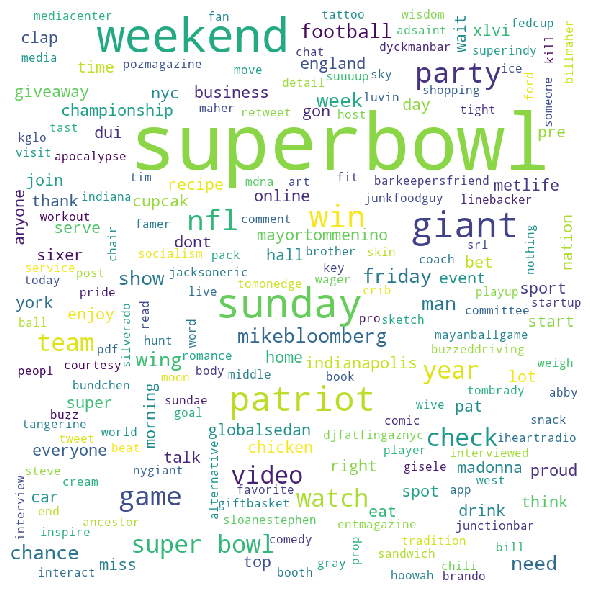

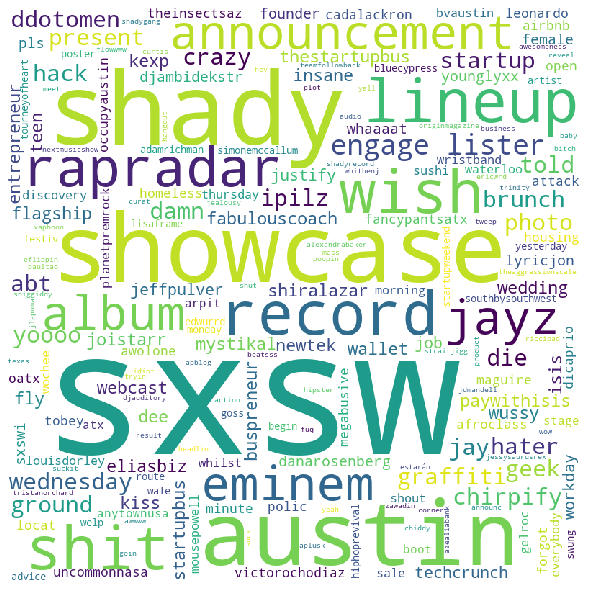

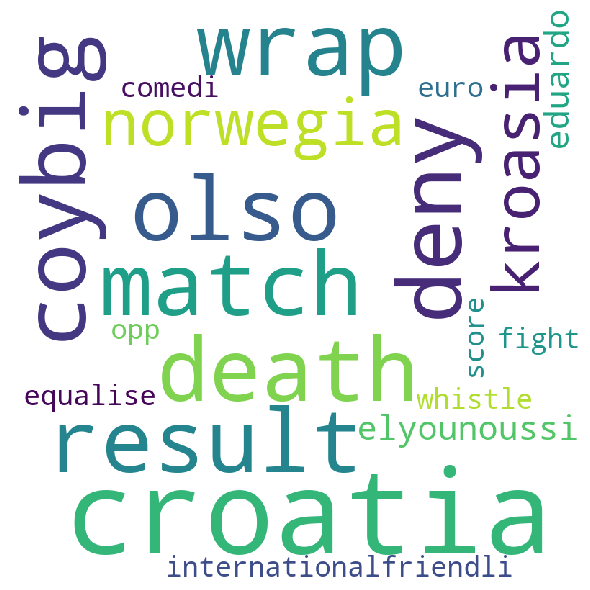

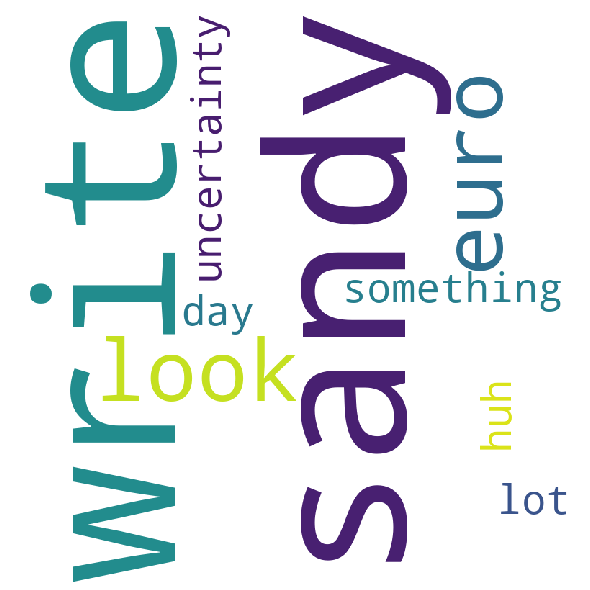

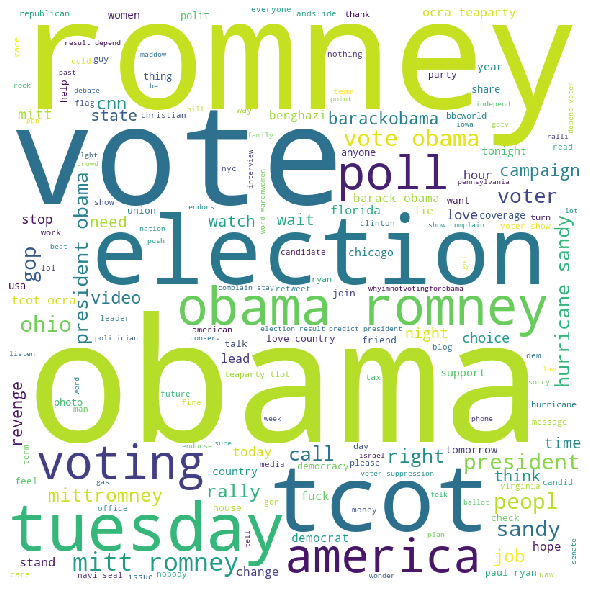

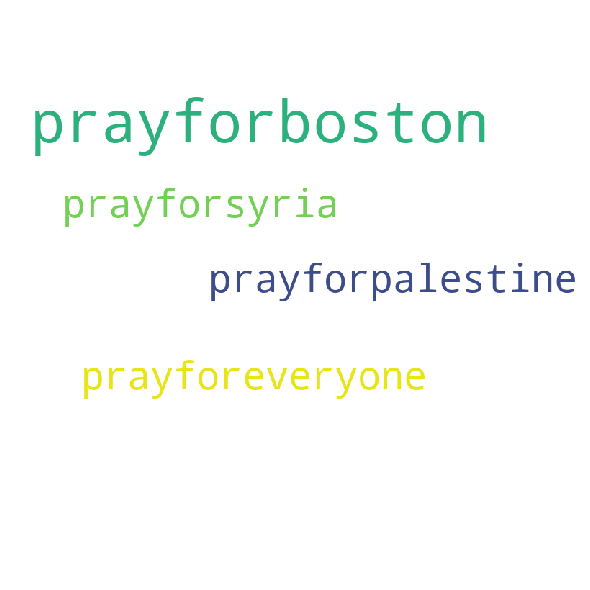

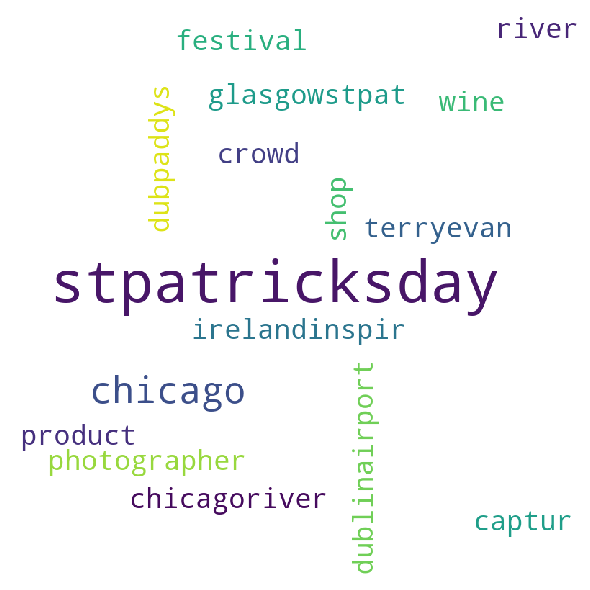

In [17]:
for i in range(len(cloud)):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(cloud[i][0])

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    name = "wordCloud_Normal_Batch1400"+str(i)+"_.png"
    plt.savefig(name,dpi=300)
    plt.show()